In [9]:
import multiprocessing as mp                                                                                                                                                                                       
import os                                                                                                                                                                                                          
import numpy as np                                                                                                                                                                                                 
import awkward as ak                                                                                                                                                                                               
import matplotlib.pyplot as plt                                                                                                                                                                                    
import matplotlib                                                                                                                                                                                                  
import matplotlib.colors as colors                                                                                                                                                                                 
from tools.roottree import read_tree                                                                                                                                                                               
from tools.selections import *                                                                                                                                                                                     
from tools.constants import MC_PARTICLE_CHARGES, MC_PARTICLE_IDS, ISOTOPES_COLOR, ISO_LABELS                                                                                                                                          
from tools.binnings_collection import mass_binning, Rigidity_Analysis_Binning_FullRange                                                                                                                         
from tools.binnings_collection import get_nbins_in_range, get_sub_binning, get_bin_center, fbinning_energy                                                                                                            
from tools.calculator import calc_mass, calc_ekin_from_beta, calc_betafrommomentom, calc_beta_from_ekin                                                                                                                           
from tools.plottools import plot1dhist, plot2dhist, plot1d_errorbar, savefig_tofile, setplot_defaultstyle, FIGSIZE_BIG, FIGSIZE_SQUARE, FIGSIZE_MID, FIGSIZE_WID, plot1d_step, FONTSIZE, set_plot_defaultstyle                               
from collections.abc import MutableMapping                                                                                                                                                                       
from tools.corrections import shift_correction                                                                                                                                                                     
import uproot                                                                                                                                                                                                      
from scipy import interpolate                                                                                                                                                                                      
from tools.studybeta import minuitfit_LL, cdf_gaussian, calc_signal_fraction, get_corrected_lipbeta_agl, get_index_correction_agl                                                                                  
import ROOT                                                                                                                                                                                                        
from ROOT import TCanvas, TFile, TProfile, TNtuple, TH1F, TH2F                                                                                                                                                     
from ROOT import gROOT, gBenchmark, gRandom, gSystem                                                                                                                                                               
from tools.functions import gaussian, asy_gaussian, poly, asy_gaussian_1d                                                                                                                                          
uproot.default_library                                                                                                                                                                                             
from iminuit import Minuit                                                                                                                                                                                         
from iminuit.cost import ExtendedBinnedNLL, LeastSquares                                                                                                                                                           
from iminuit.util import describe, make_func_code                                                                                                                                                                  
from tools.constants import ISOTOPES, NUCLEI_NUMBER, DETECTOR_COLOR, ANALYSIS_RANGE_EKIN
from tools.constants import ISOTOPES_MASS, NUCLEI_CHARGE, NUCLEIS, ISOTOPES
from tools.histograms import WeightedHistogram, Histogram, plot_histogram_2d, plot_histogram_1d                                                                                                                    
from tools.binnings import Binning, make_lin_binning                                                                                                                                                               
from tools.graphs import MGraph, plot_graph, get_nppolyfit                                                                                                                                                         
from scipy.interpolate import UnivariateSpline  
from scipy.optimize import curve_fit
from tools.utilities import power_law_v2, power_law, fit_flux
from tools.graphs import MGraph, slice_graph, plot_graph, slice_graph_by_value, concatenate_graphs
from tools.utilities import get_spline_from_graph, save_spline_to_file, get_graph_from_spline, get_spline_from_file

In [10]:
datadirP8 = '/home/manbing/Documents/Data/data_LiP8/'
resultsdir = '/home/manbing/Documents/Data/data_LiP8/results'
nuclei = 'Li'

countsdir = '/home/manbing/Documents/lithiumanalysis/scripts/plots/LiP8/fitData/'
file_counts = '/home/manbing/Documents/lithiumanalysis/scripts/plots/LiP8/fitDataB1236_rebin/graph_massfit_counts.npz'
file_acc = datadirP8 + 'acceptance/LiMC_dict_graph_rawacc_EkinP8.npz'

file_expotime = datadirP8 + 'expotime/expotime_p8rebin.root'

#file_effcor = datadirP7 + 'graph_total_effcor.npz'
file_effcor = datadirP8 + 'efficiency/spline_effcor/graph_total_effcor.npz'

plotdir = f'/home/manbing/Documents/lithiumanalysis/slides/plots/LiFoward_Unfolding_InBeta_FluxPowerLaw_PASS8'
os.makedirs(plotdir, exist_ok=True)

detectors = ["Tof", "NaF", "Agl"]
isotopes = ISOTOPES[nuclei]
isotopes_alias = {'Be7': 'be7', 'Be9': 'be9', 'Be10': 'be10', 'Li6': 'li6', 'Li7':'li7'}
detectors_alias = {"Tof":"tof", "NaF":"naf", "Agl": "agl"} 
OptimizedDataSample = [iso for iso in ISOTOPES[nuclei]] 
variable = 'Ekin'
fig_suffix = 'P8'
slicevalue ={'Tof':[0.4185, 1.5473], 'NaF':[1.1666, 4.05], 'Agl':[4.0029, 12.13]}
isrebin = True
if isrebin:
    xbinning = Binning(fbinning_energy_rebin())
else:
    xbinning = Binning(fbinning_energy())
FIGNAME = 'B1236'

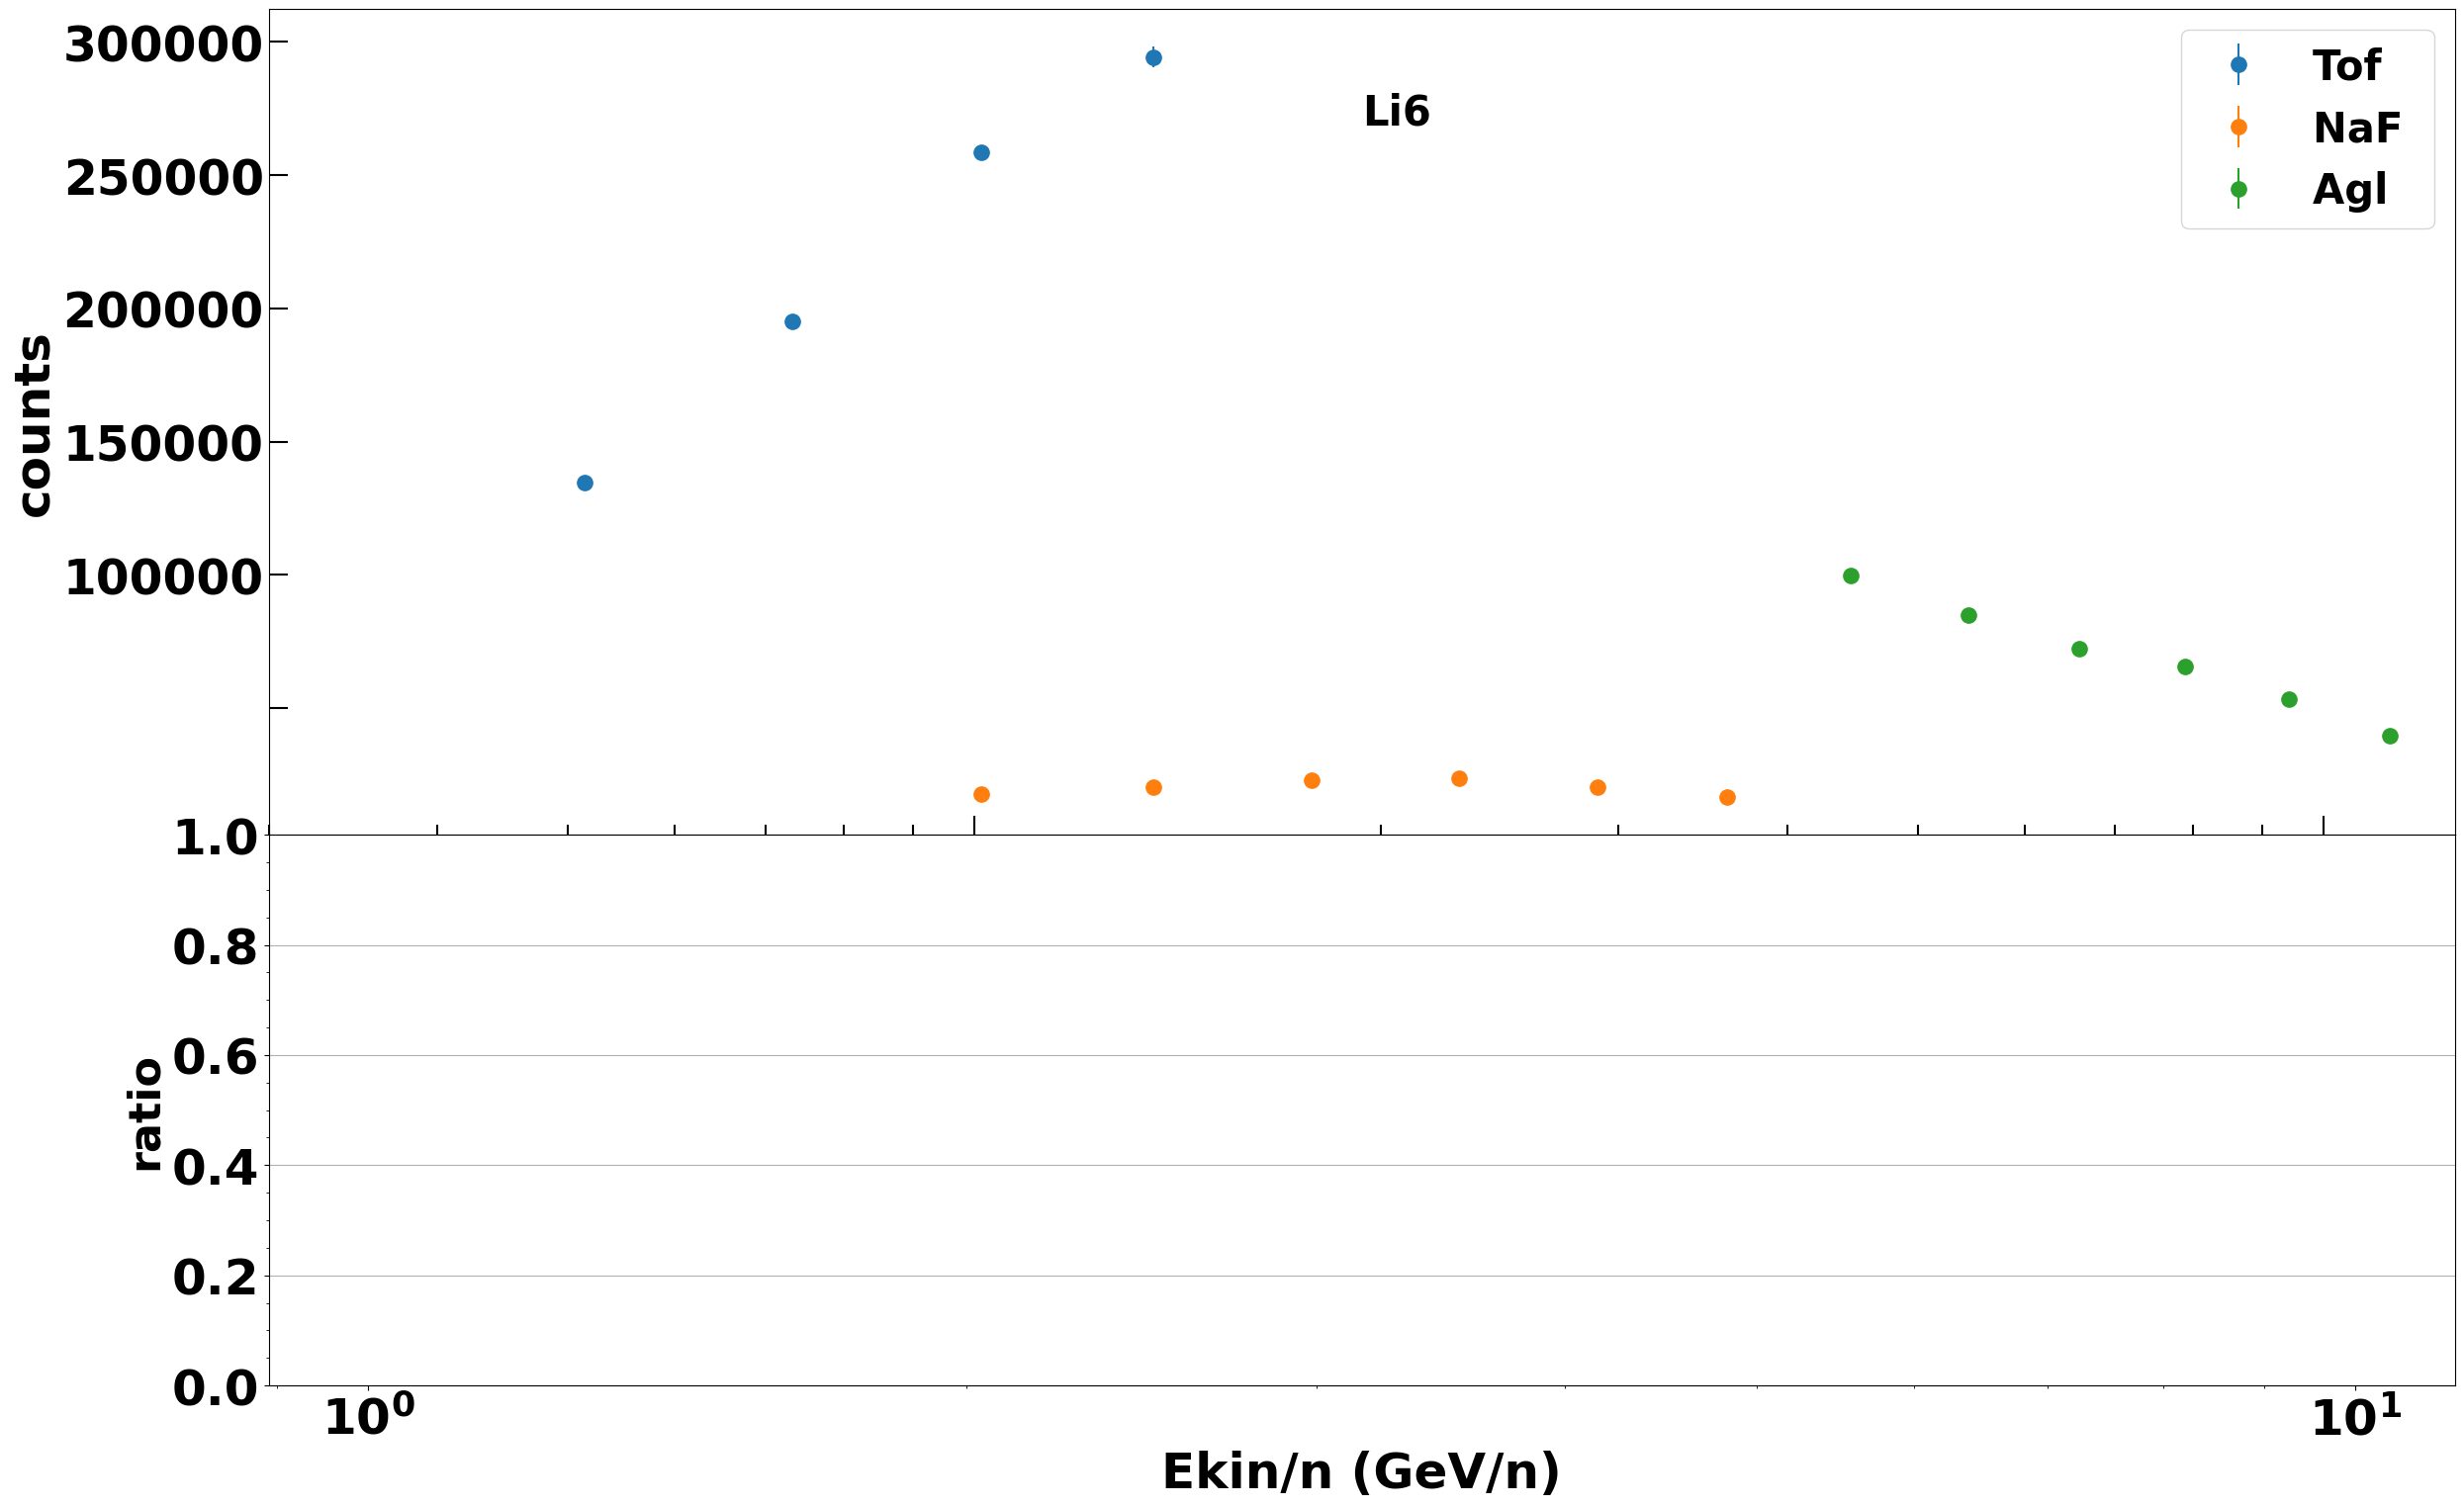

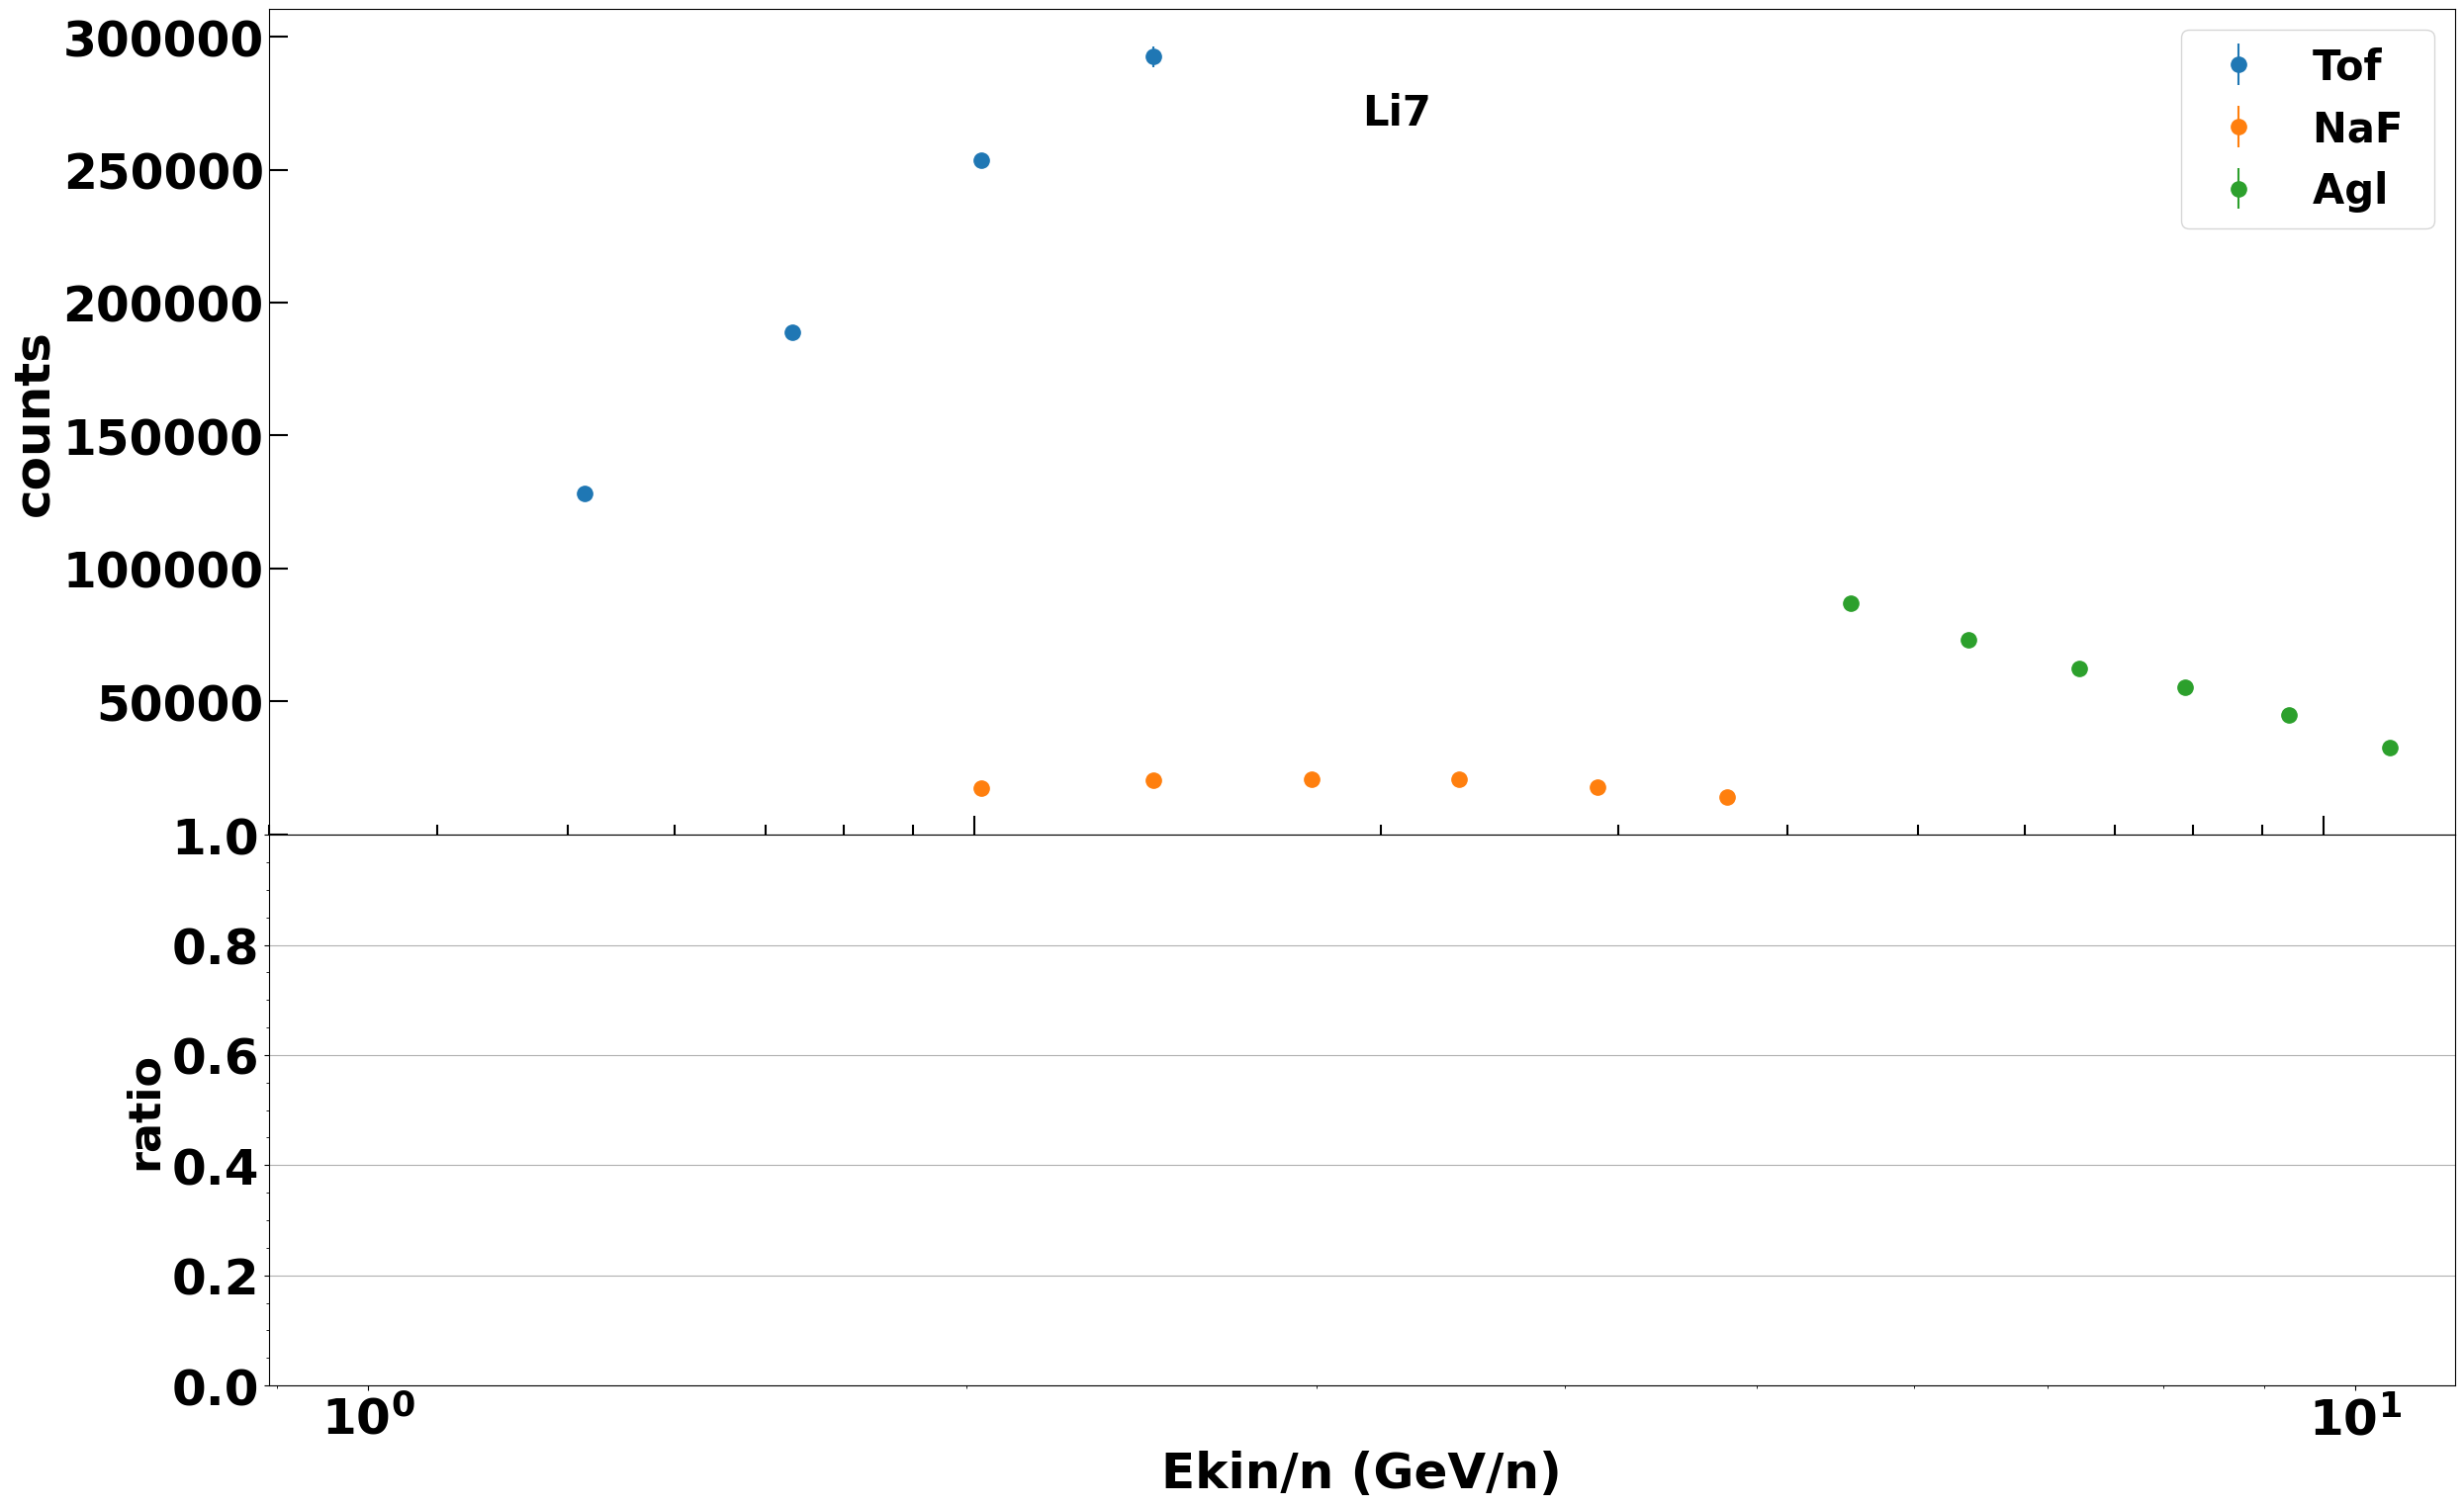

In [11]:
import pandas as pd 
detectors_alias = {"Tof":"tof", "NaF":"naf", "Agl": "agl"} 
detectors = ["Tof", "NaF", "Agl"]
isotopes = ["Li6", "Li7"]
slicevalue ={'Tof':[0.45, 1.3], 'NaF':[1.1, 4.0], 'Agl':[4.2, 12.0]}
temp = 'Li6'
ratiolim = {'Be7':[0.9, 1.1], 'Be9':[0.8, 1.2], 'Be10':[0.6, 1.4]}

filename = '/home/manbing/Documents/lithiumanalysis/scripts/plots/LiP8/fitDataB1236_rebin/graph_massfit_counts.npz'
plotdir = '/home/manbing/Documents/lithiumanalysis/scripts/plots/LiP8/fitDataB1236_rebin/'

                                                                                                                                                 
df_counts = np.load(f'{filename}')
#df_counts_compare = np.load(f'{filename_init}')
detectors = ['Tof', 'NaF', 'Agl']
figSize = (22, 15)
graph_counts_fromfit = {dec: {} for dec in detectors}
graph_counts_sum = dict()

hist_mass2d = {dec: {} for dec in detectors}
xbinning = Binning(fbinning_energy())

for dec in detectors:
    for iso in isotopes:
        graph_counts_fromfit[dec][iso] = MGraph.from_file(df_counts, f"graph_counts_{dec}Opt{temp}_{iso}")
        graph_counts_fromfit[dec][iso] = slice_graph_by_value(graph_counts_fromfit[dec][iso], slicevalue[dec])
        xstart = graph_counts_fromfit[dec][iso].xvalues[0]
        xend = graph_counts_fromfit[dec][iso].xvalues[-1]
        
for iso in isotopes: 
    fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios':[0.6, 0.4]}, figsize=(26, 16))                                                                                                            
    fig.subplots_adjust(left= 0.12, right=0.97, bottom=0.08, top=0.95) 
    for dec in detectors:
        plot_graph(fig, ax1, graph_counts_fromfit[dec][iso], color=DETECTOR_COLOR[dec],  style="EP", xlog=True, ylog=False, scale=None, markersize=22, label=f'{dec} ')  
        
        
        if iso == "Li6":
            graph_counts_sum[dec] = graph_counts_fromfit[dec][iso]
        else:
            graph_counts_sum[dec] = graph_counts_sum[dec] + graph_counts_fromfit[dec][iso]
        
    ax1.set_xlim([0.3, 12.5]) 
    ax2.grid(axis='y')
    ax2.set_xlabel('Ekin/n (GeV/n)') 
    ax1.legend(loc="upper right", fontsize=30) 
    ax1.set_xticklabels([])
    plt.subplots_adjust(hspace=.0)   
    ax1.get_yticklabels()[0].set_visible(False)
    ax1.set_ylabel('counts')

    ax1.legend(loc="upper right", fontsize=30) 
    ax1.set_xticklabels([])

    plt.subplots_adjust(hspace=.0)   
    ax1.get_yticklabels()[0].set_visible(False)
    ax1.set_xscale('log')
    ax2.set_xscale('log')
    ax2.set_ylabel('ratio', fontsize=32)
    
    #ax2.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    #ax2.set_xticks(np.array([2, 4, 10]))
    ax1.text(0.5, 0.9, f'{iso}', fontsize=30, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color='black')
    savefig_tofile(fig, plotdir, f"compare_counts_fromfit_T{temp}N{iso}_v23fix", show=True) 

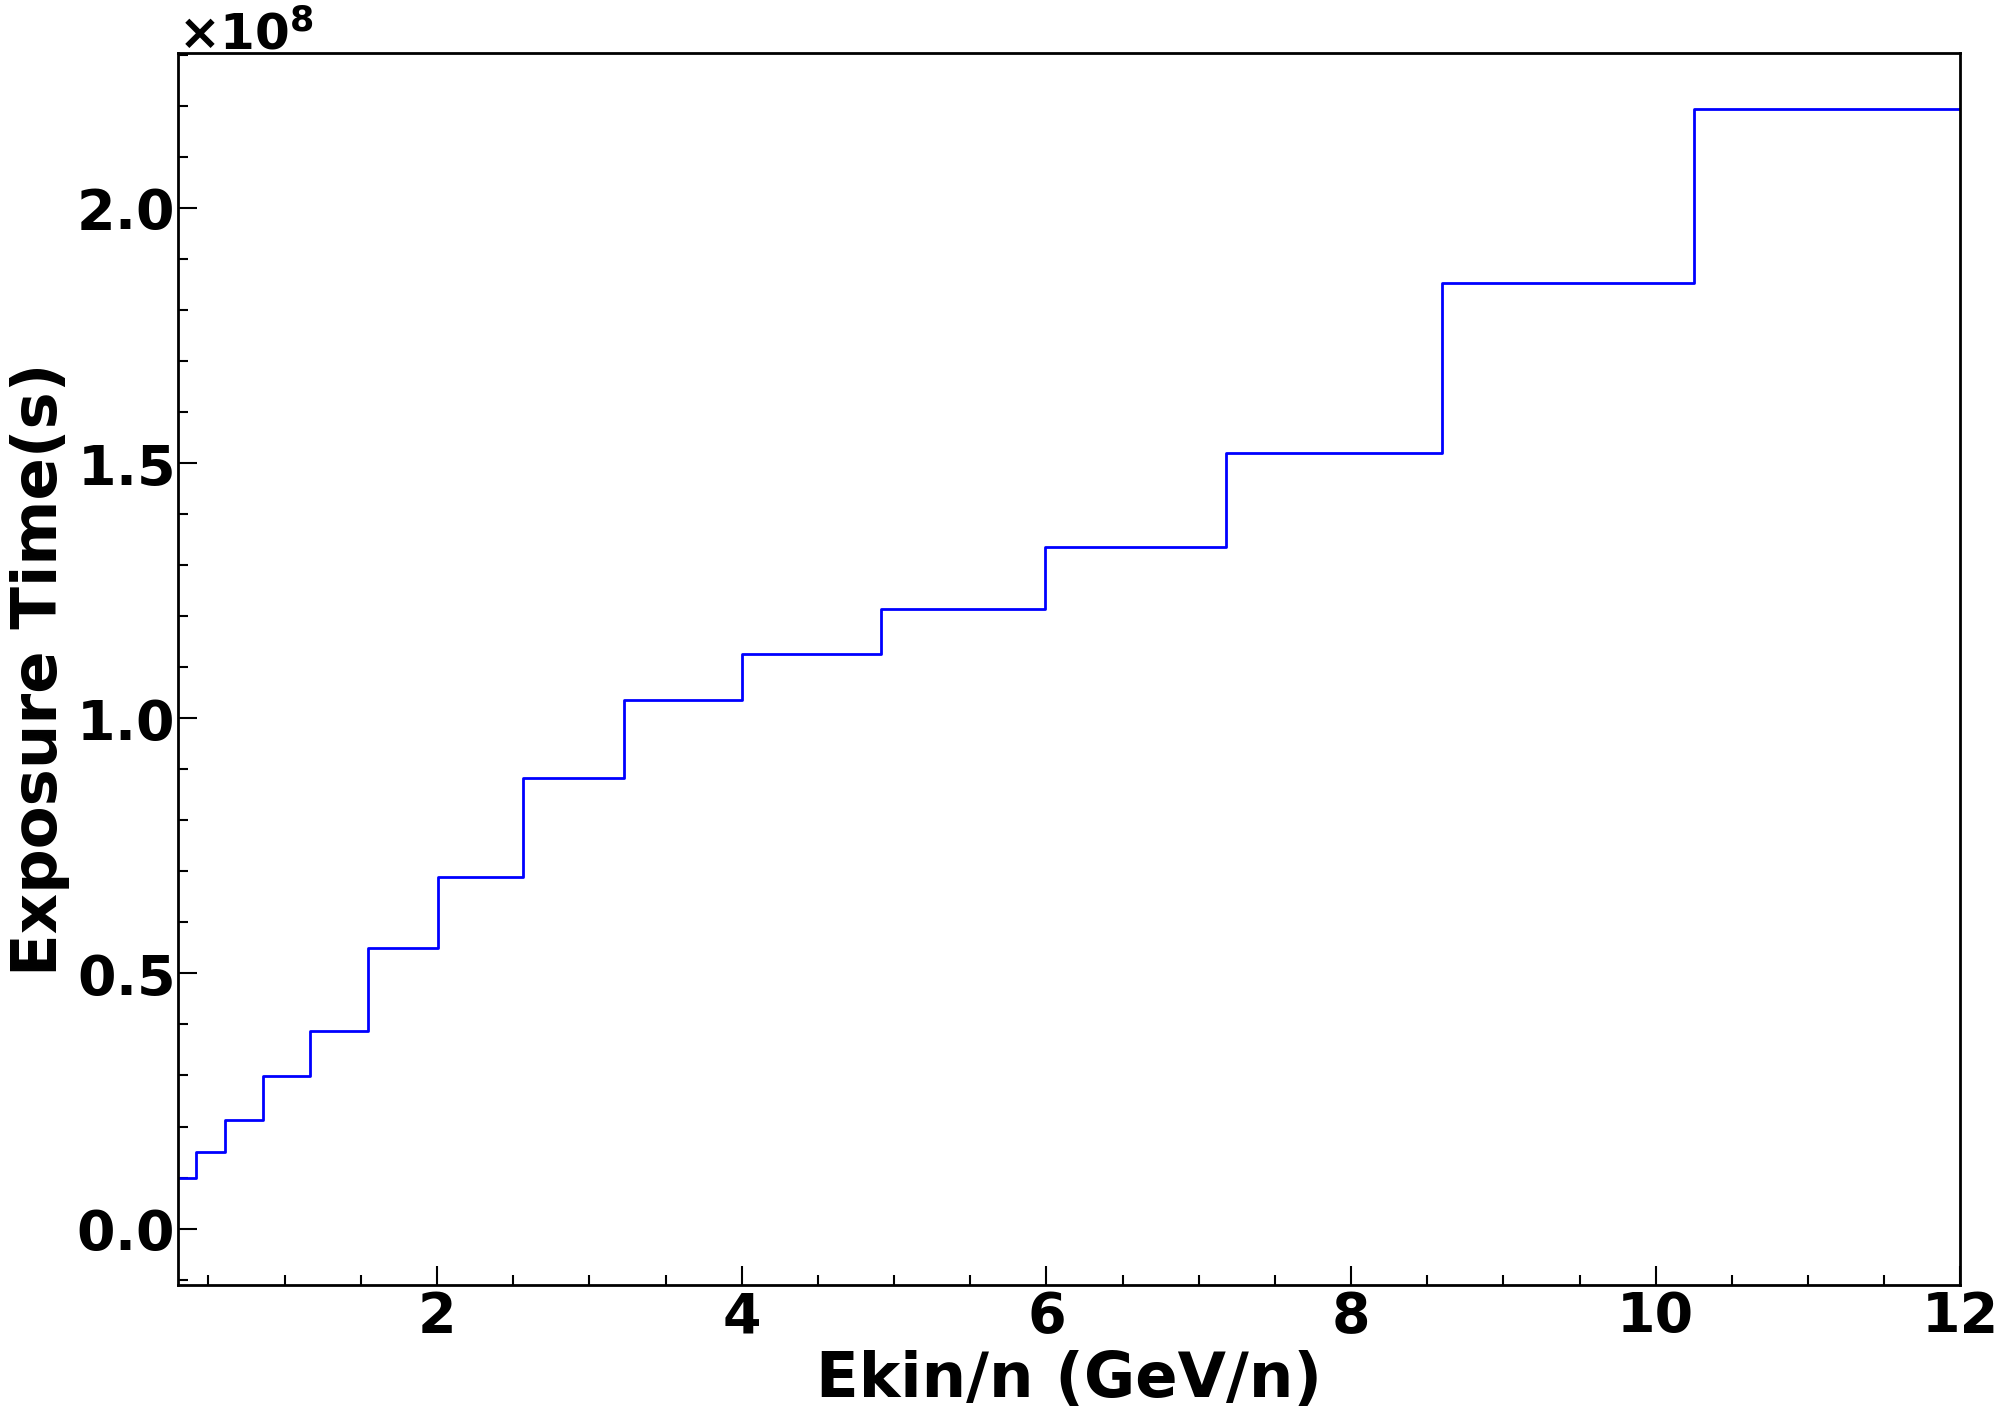

In [12]:

hist_time = dict()
graph_measuretime = dict()
This_COLOR = {'Be7': 'tab:blue', 'Be9': 'tab:green', 'Be10':'red', 'Li6':'blue'}
with uproot.open(file_expotime) as filetime:  
    for iso in isotopes:
        if isrebin:
            hist_time[iso] = filetime[f'h_expo_rig_1_{isotopes_alias["Be7"]}_rebin'] 
        yexpotime = hist_time[iso].values()                           
        xvalue_time = hist_time[iso].axes[0].edges() 
        graph_measuretime[iso] = MGraph(get_bin_center(xvalue_time), yexpotime, np.zeros_like(yexpotime)) 

figure, ax1 = plt.subplots(1, 1, figsize=(23, 16))
for i, iso in enumerate(['Li6']):                                                                                                                                                                                                                                                                                                                                                                    
    plot1d_step(figure, ax1, hist_time[iso].axes[0].edges(), hist_time[iso].values(), err=None, label_x="Ekin/n (GeV/n)", label_y="counts",  legend=None, col=None, legendfontsize=18, setlogx=False, setlogy=False, setscilabelx=False, setscilabely=True, figsize=(12, 9),  tick_length=14, tick_width=1.5, color=This_COLOR[iso], linewidth=2)
    #plot1d_step(figure, ax1, hist_time_JH[iso].axes[0].edges(), hist_time[iso].values(), err=None, label_x="Ek/n(GeV/n)", label_y="counts",  legend=None, col=None, legendfontsize=18, setlogx=False, setlogy=False, setscilabelx=False, setscilabely=False, figsize=(12, 9),  tick_length=14, tick_width=1.5, color='black')
    ax1.set_xlim([0.3, 12])
    ax1.set_ylabel('Exposure Time(s)',fontsize=45)
    ax1.set_xlabel("Ekin/n (GeV/n)", fontsize=45)
    ax1.tick_params(axis='both', labelsize=40)
    savefig_tofile(figure, plotdir, f"Li_measuring_time_P811yr", 1)   

    

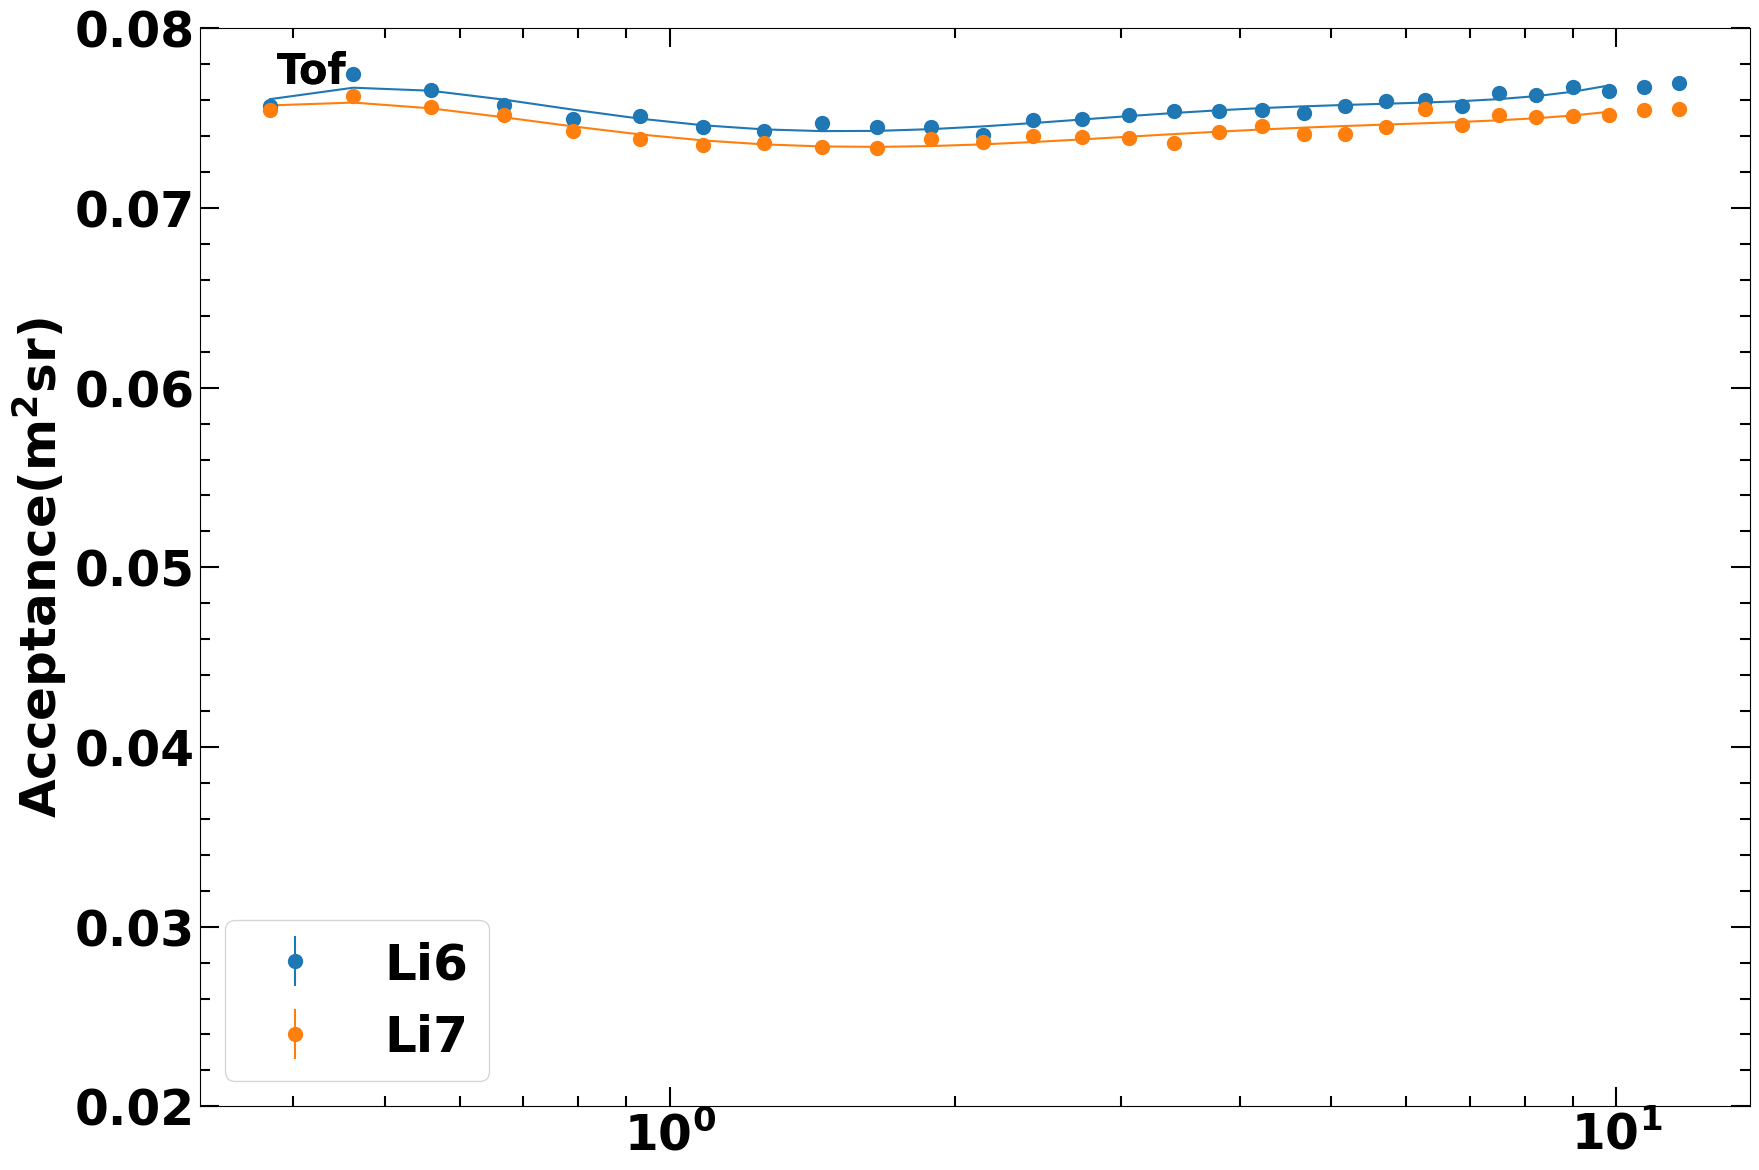

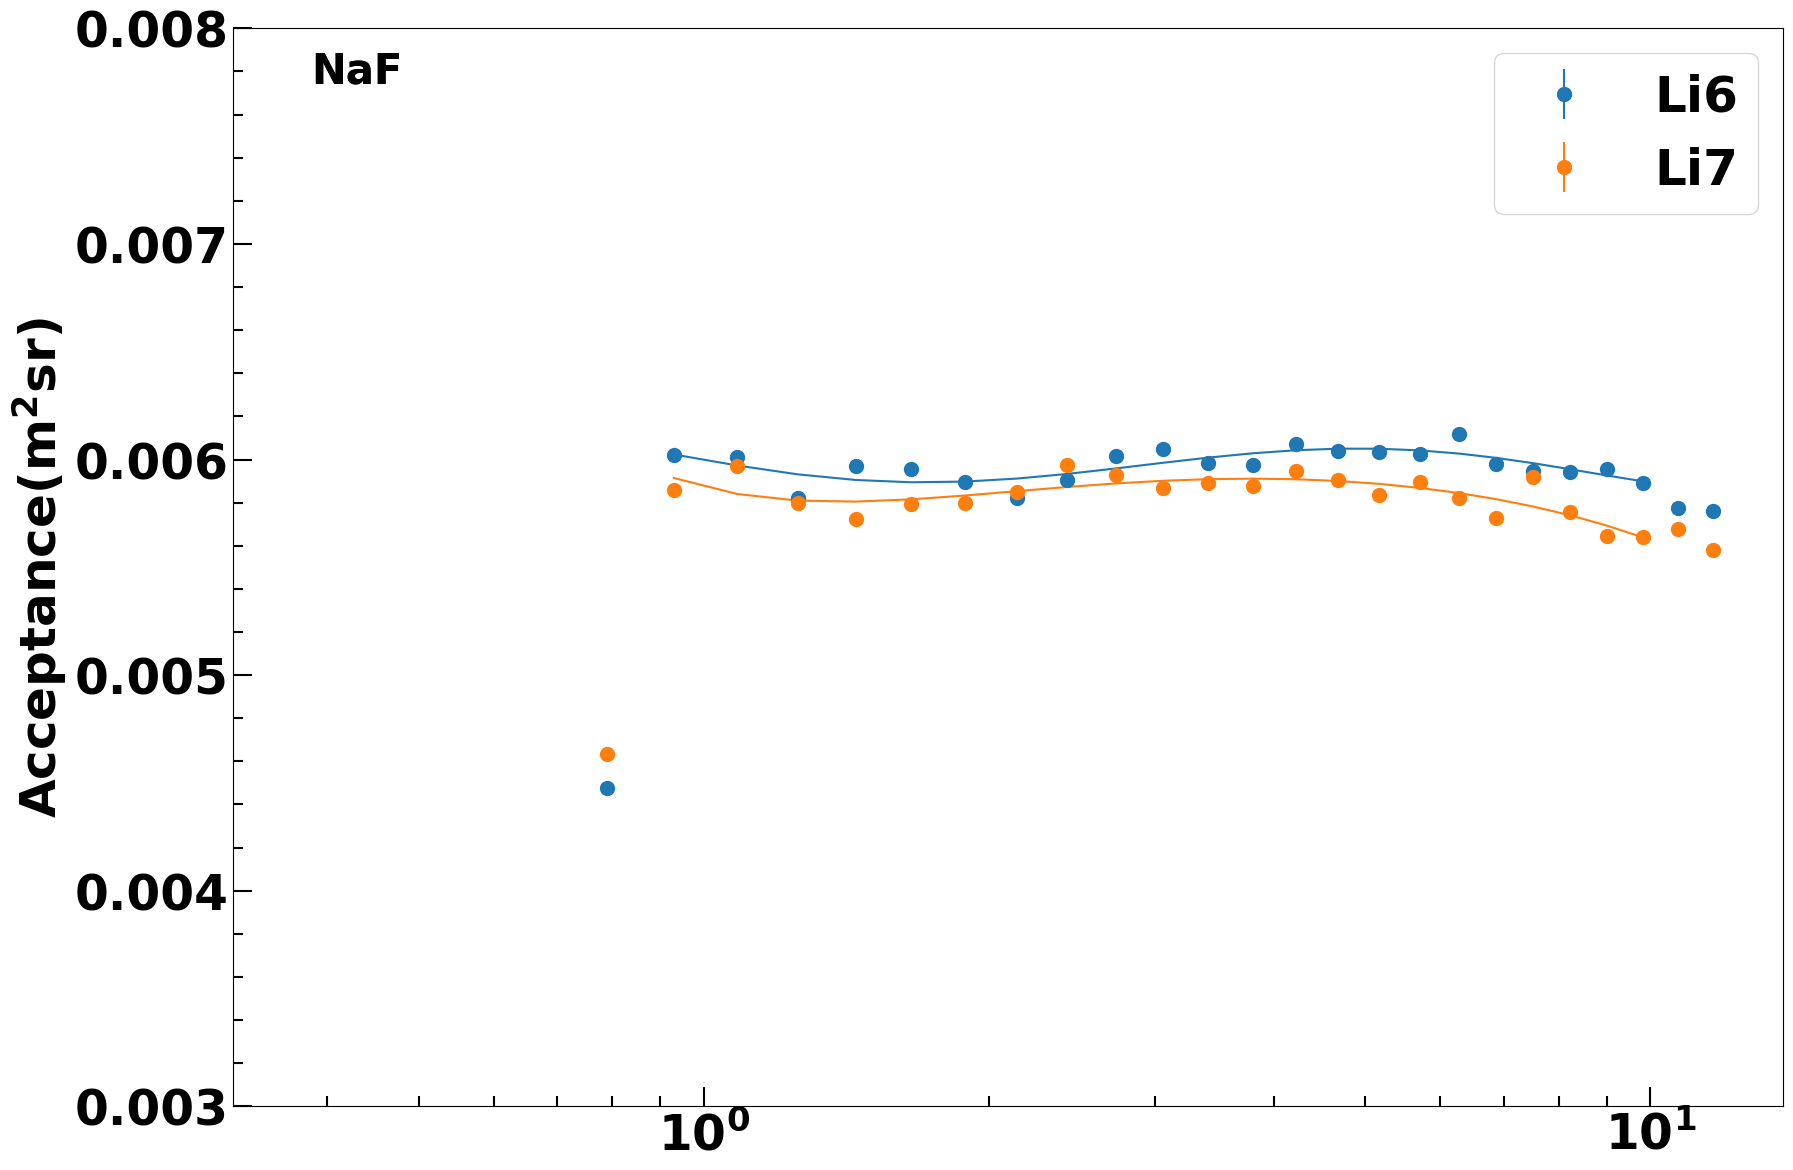

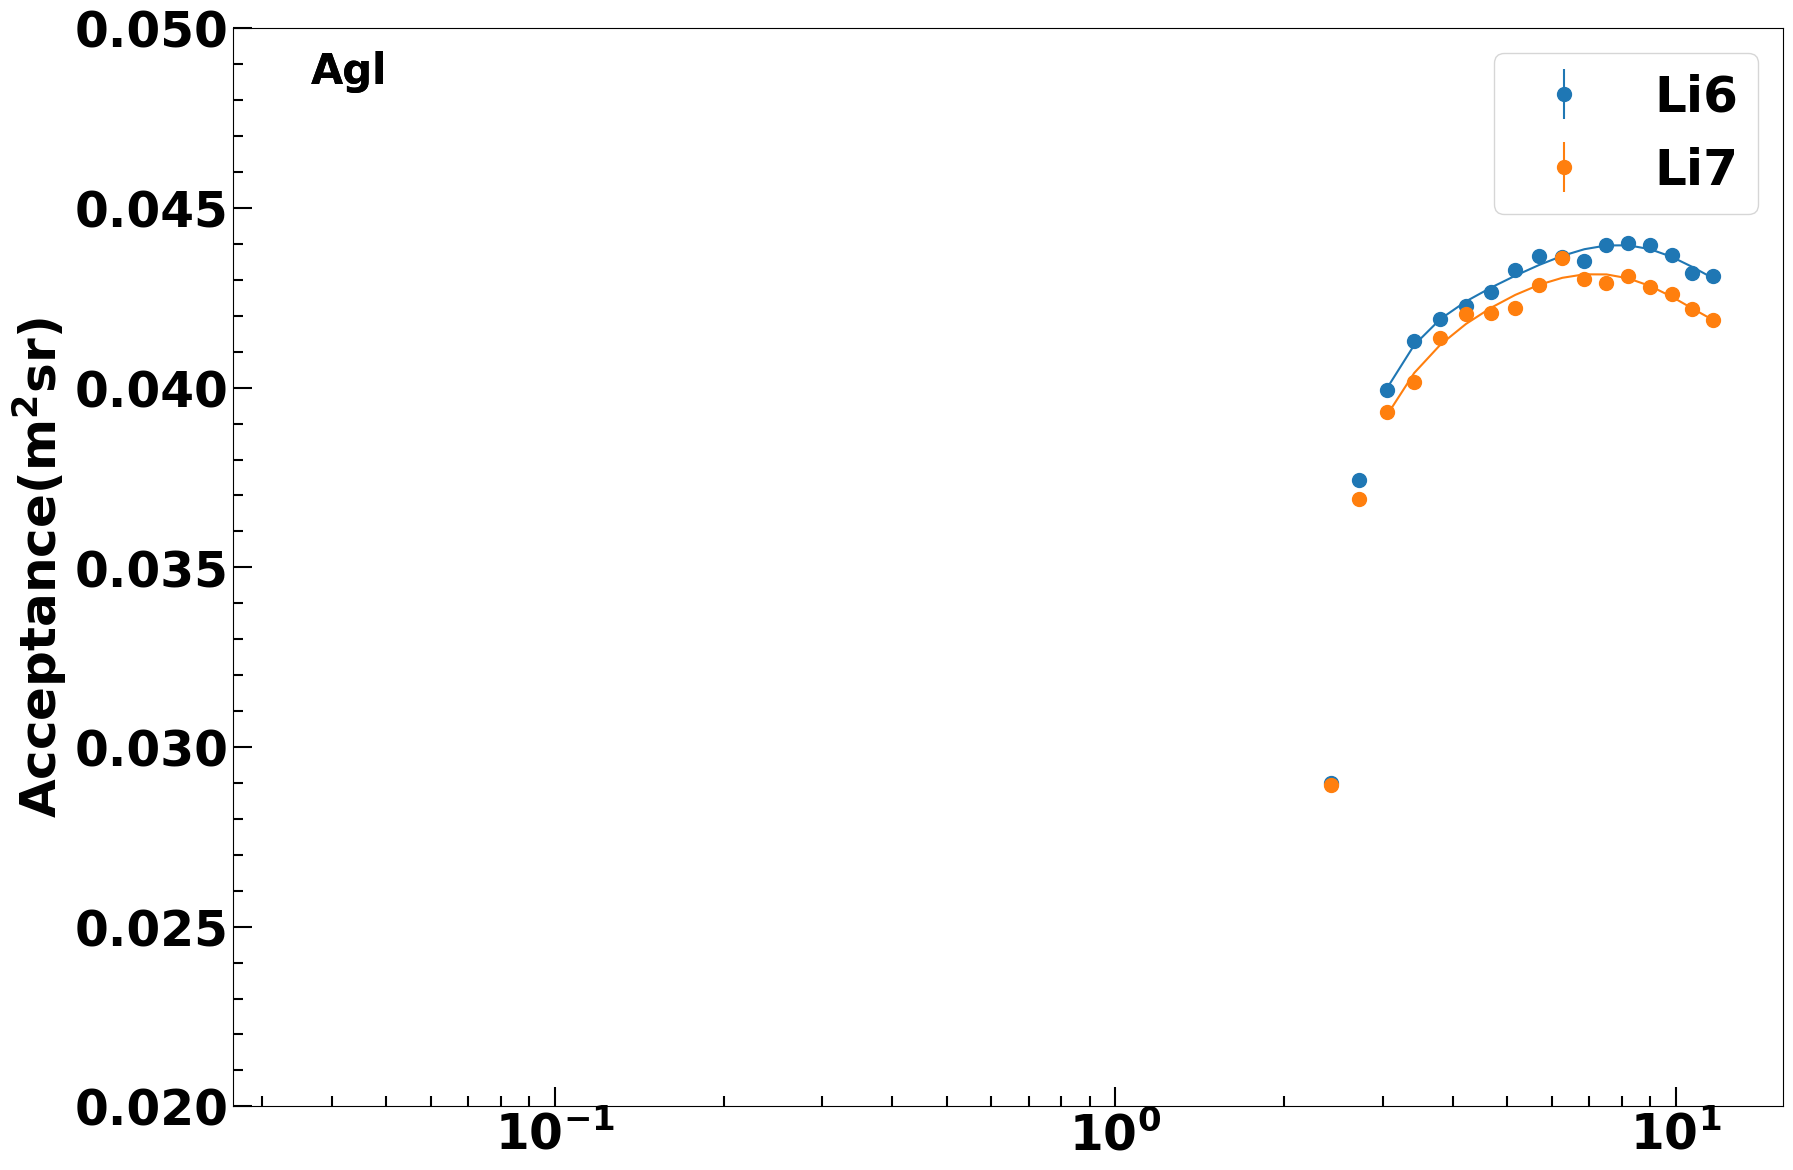

In [13]:
detectors = ['Tof', 'NaF', 'Agl']

variable = 'Ekin'

with np.load(f'{file_acc}') as facc:                                                                                                                
    graph_acc = {dec: {iso: MGraph.from_file(facc, f"raw_acc_{dec}_{iso}") for iso in ISOTOPES[nuclei]} for dec in detectors}                                                                              
    
ylim_range = {'Tof': [0.02, 0.08], "NaF": [0.003, 0.008], "Agl": [0.02, 0.05]}
xlim_range = {'Tof': [0.2, 10], 'NaF':[1.0, 10], "Agl":[3.0, 12]}
subgraph_acc =  {dec: {} for dec in detectors}
spline_subgraph_acc =  {dec: {} for dec in detectors}
graph_acc_fromspline = {dec: {} for dec in detectors}
for dec in detectors:                                                                                                                                                                                          
    figure, ax1 = plt.subplots(1, 1, figsize=(20, 14))                                                                                                        
    for i, iso in enumerate(ISOTOPES[nuclei]): 
        subgraph_acc[dec][iso] = slice_graph_by_value(graph_acc[dec][iso], xlim_range[dec])
        x_values = subgraph_acc[dec][iso].xvalues
        spline_subgraph_acc[dec][iso] = UnivariateSpline(np.log(subgraph_acc[dec][iso].xvalues),subgraph_acc[dec][iso].yvalues, k=5, s=5)  
        
        ax1.plot(x_values, spline_subgraph_acc[dec][iso](np.log(x_values)))
        #acc_corr = graph_acc[dec][iso].yvalues * graph_total_effcor_ekin[dec][iso].yvalues                                                                                                                     
        #graph_corrected_acc[dec][iso] = MGraph(xbinning["Ekin"].bin_centers[1:-1], acc_corr, graph_acc[dec][iso].yerrs)                                                                                                                                                                                                                                                                                                  
        plot_graph(figure, ax1, graph_acc[dec][iso], color=ISOTOPES_COLOR[iso], label=f"{iso}", style="EP", xlog=True, ylog=False, markersize=20)                                                                            
        #plot_graph(figure, ax1, graph_corrected_acc[dec][iso], color=ISOTOPES_COLOR[iso], label=f"{iso}", style="EP", xlog=True, ylog=False, markersize=20)                                                    
        ax1.legend()                                                                                                                                                                                                                                                                                                                                                                       
        ax1.set_xscale("log")   
        ax1.set_ylim(ylim_range[dec])
        ax1.set_ylabel(r"$\mathrm{Acceptance (m^{2} sr)}$")                                                                                                                                                    
        ax1.text(0.05, 0.98, f"{dec}", fontsize=30, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black", weight='bold')                                                                                                                                                                                                                                                           
    #savefig_tofile(figure, plotdir, f"acc_{nuclei}_{dec}_{variable}", 1)

[4.22975787e-07 4.49316432e-07 4.68136363e-07 4.82435058e-07]
[4.77104170e-07 5.06812573e-07 5.28043866e-07 5.44176815e-07]
[4.68808277e-07 4.83130627e-07 4.95840368e-07 5.09515749e-07
 5.24149268e-07 5.40588928e-07]
[5.28791645e-07 5.44948894e-07 5.59283101e-07 5.74706291e-07
 5.91215215e-07 6.09757207e-07]
[5.51910355e-07 5.50792140e-07 5.90025021e-07 5.87607629e-07
 5.98688829e-07 6.18463757e-07]
[6.22533857e-07 6.21275393e-07 6.65524425e-07 6.62803737e-07
 6.75305008e-07 6.97612671e-07]

xvalues			yvalues			yerrs
0.5144			0.008935887085663341			0.00014548945315361202
0.7332			0.009161021011155552			8.599373789655167e-05
1.01135			0.008671949700234024			7.780760260387217e-05
1.3569499999999999			0.000527771828373056			6.350097064115954e-06
1.7779			0.0004134324454971383			4.454500554875706e-06
2.28735			0.0003426608049819059			3.65566550663305e-06
2.8959			0.00022872675028749493			2.610530207167065e-06
3.61425			0.00016151679854110724			2.244556047240183e-06
4.45875			0.000887395520

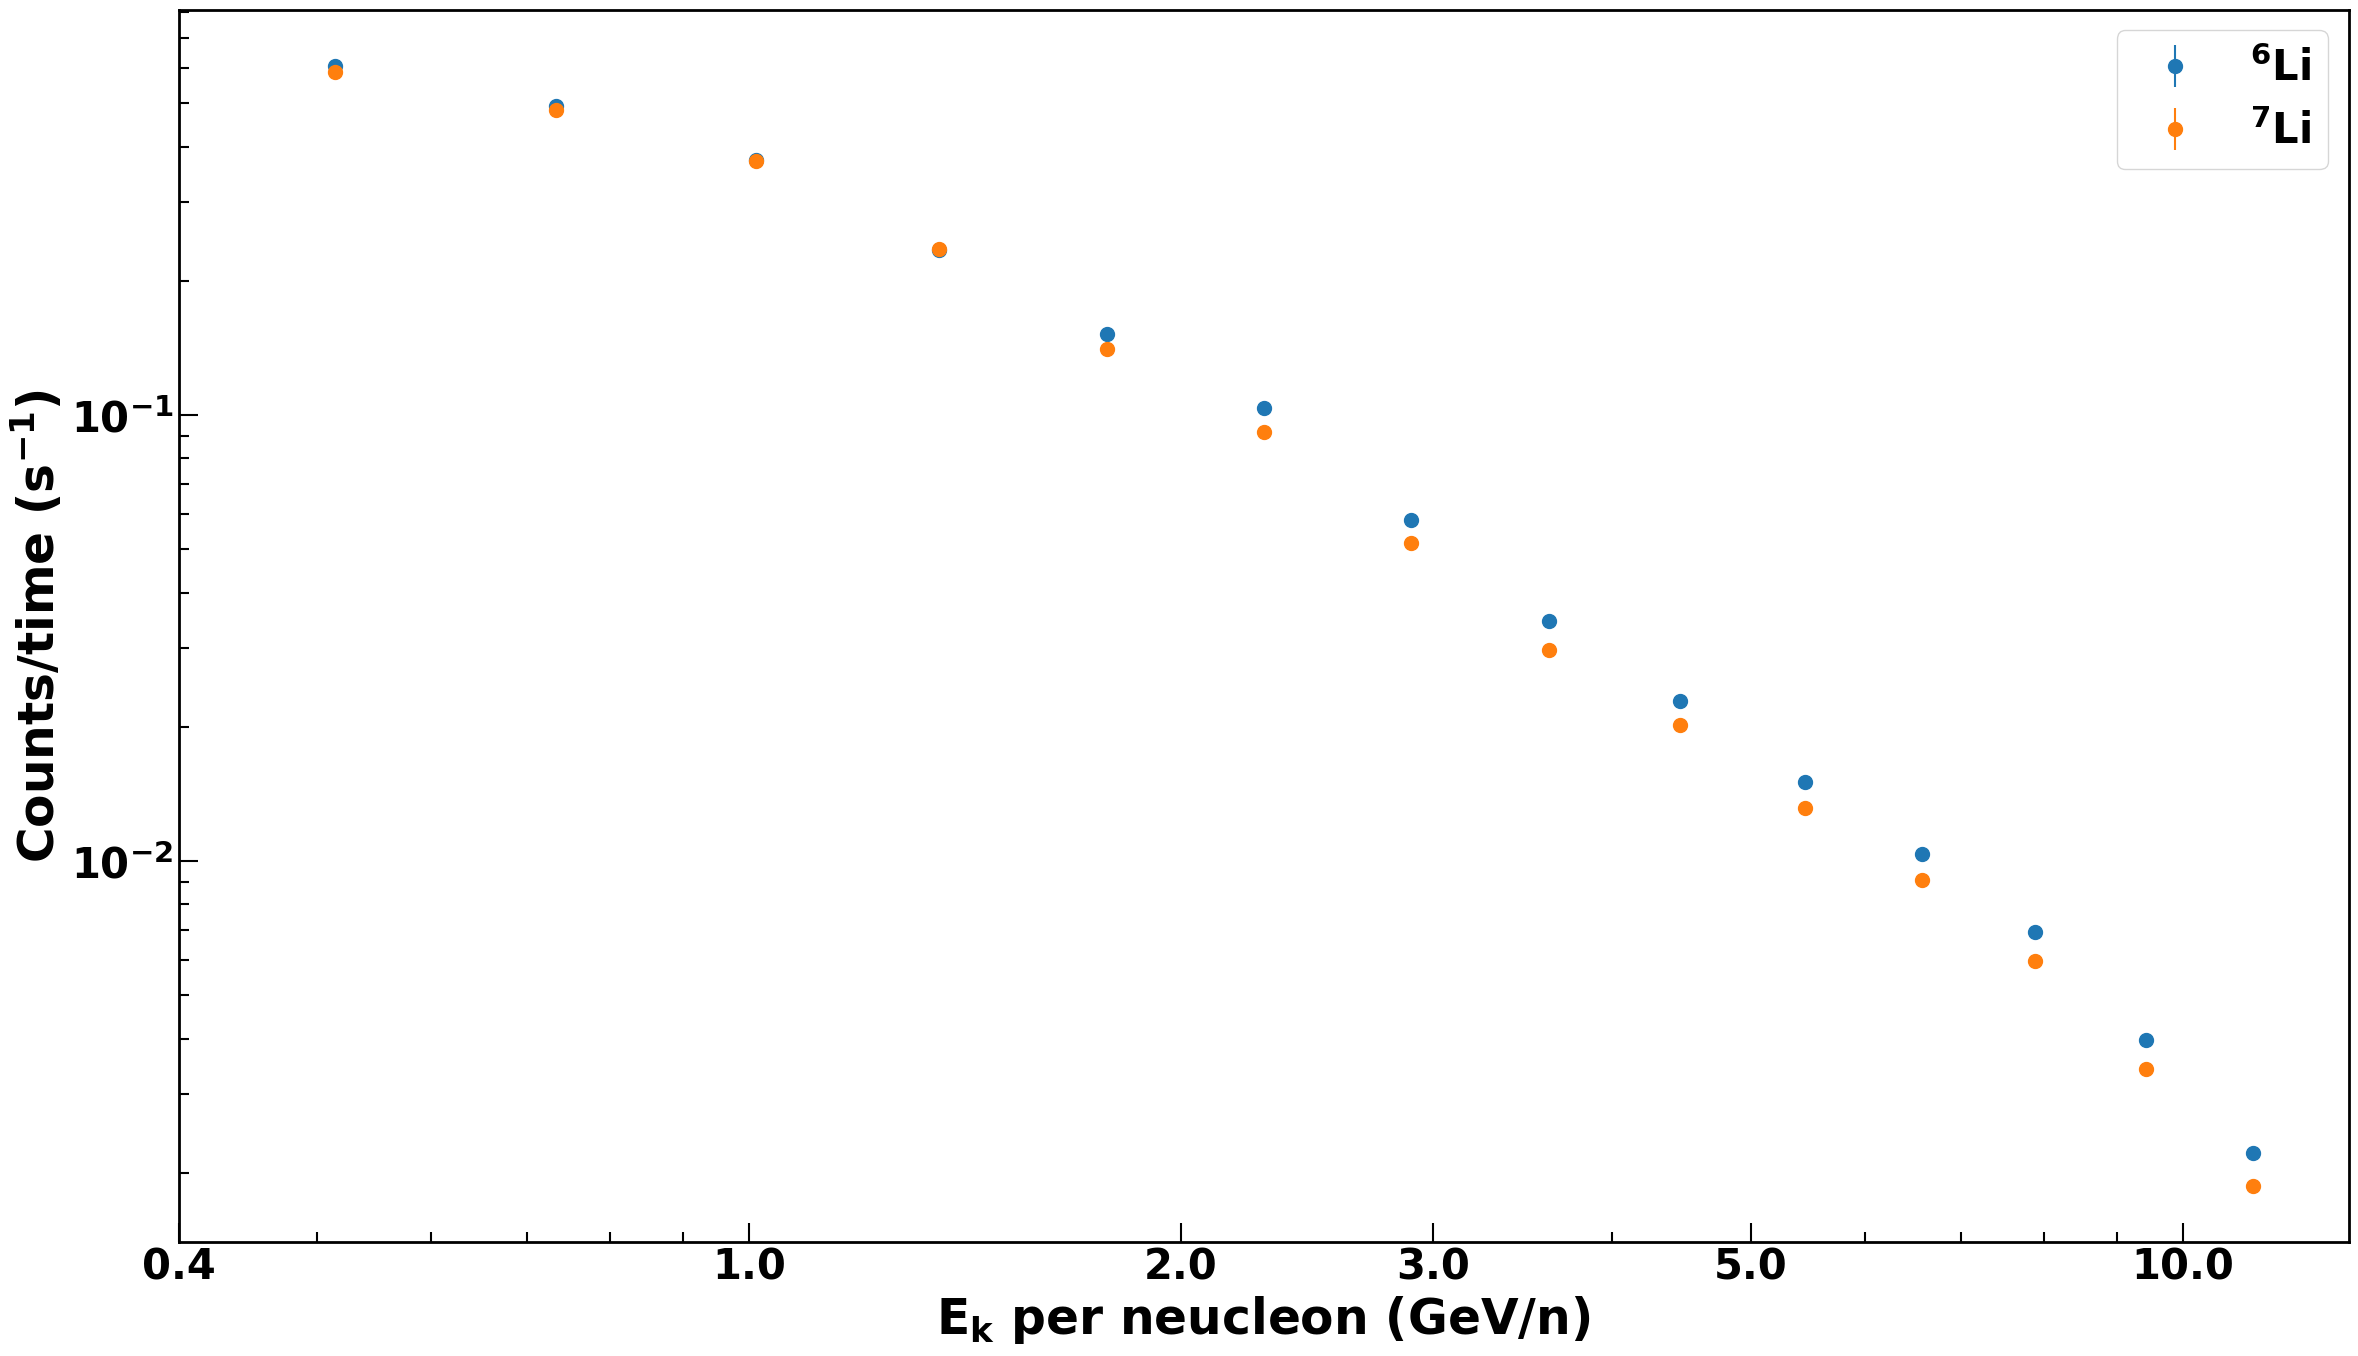

In [14]:
graph_rawflux = {dec: dict() for dec in detectors}  
graph_rawflux_combined = dict()
graph_measured_rate = {dec: dict() for dec in detectors} 
graph_measured_rate_combined = dict()
df_measure_rate = dict()
xbinning = {"Rigidity": Binning(fbinning_energy()), "Ekin":Binning(fbinning_energy_rebin())}   
for dec in detectors:                                                                                                                                                                                          
    for iso in ISOTOPES[nuclei]:                                                                                                                                                                               
        xenergy = graph_counts_fromfit[dec][iso].xvalues    
        counts = graph_counts_fromfit[dec][iso].yvalues 
        counts_err = graph_counts_fromfit[dec][iso].yerrs                                                                                                                                                              
        #effcor = slice_graph_by_value(graph_total_effcor_ekin[dec][iso], [xenergy[0], xenergy[-1]])                                                                                                            
        acc = spline_subgraph_acc[dec][iso](np.log(xenergy))  
        graph_acc_forerr = slice_graph_by_value(graph_acc[dec][iso], [xenergy[0], xenergy[-1]])  
        acc_err = graph_acc_forerr.yerrs[0::2]
        time = slice_graph_by_value(graph_measuretime[iso], [xenergy[0], xenergy[-1]])   
        print(acc_err)

        meas_rate = counts/time.yvalues
        meas_rate_err = counts_err/time.yvalues
        graph_measured_rate[dec][iso] = MGraph(xenergy, meas_rate, meas_rate_err)
        graph_measured_rate[dec][iso].add_to_file(df_measure_rate, f'graph_measured_rate_{dec}{iso}')
        indices = xbinning['Ekin'].get_indices([xenergy[0], xenergy[-1]])                                                                                                                                    
        #bin_widths = xbinning[variable].bin_widths[indices[0]: indices[1]+1]                                                                                                                                  
        bin_edges = xbinning['Ekin'].edges[indices[0]: indices[1]+2]                                                                                                                                         
        bin_widths = bin_edges[1:] - bin_edges[:-1]                                                                                                                                                            
        #assert (np.all(xenergy == effcor.xvalues))                                                                                                                                                                                                                                                                                                                             
        assert (np.all(xenergy == time.xvalues))                                                                                                                                                               
        assert (np.all(xenergy == get_bin_center(bin_edges))) 
        
        flux_raw = counts /(acc *time.yvalues * bin_widths)    
        
        flux_raw_err = flux_raw * np.sqrt((counts_err/counts)**2 + (acc_err/acc)**2)                                                                                                                         
        graph_rawflux[dec][iso] = MGraph(xenergy, flux_raw, flux_raw_err)                                                                                                                                                 
        #print(graph_flux_raw[dec][iso])
        
Range ={"Tof": [0.41, 1.1], "NaF":[1.2, 4.0], "Agl":[4.2, 12.0]}       
for iso in ISOTOPES[nuclei]:
    graph_rawflux_combined[iso] = concatenate_graphs(slice_graph_by_value(graph_rawflux["Tof"][iso], Range["Tof"]), slice_graph_by_value(graph_rawflux["NaF"][iso], Range["NaF"]))                                                                     
    graph_rawflux_combined[iso] = concatenate_graphs(graph_rawflux_combined[iso], slice_graph_by_value(graph_rawflux["Agl"][iso], Range["Agl"]))                                                                                                       
    graph_rawflux_combined[iso].add_to_file(df_measure_rate, f'graph_rawflux_combined_{iso}')
    graph_measured_rate_combined[iso] = concatenate_graphs(slice_graph_by_value(graph_measured_rate["Tof"][iso], Range["Tof"]), slice_graph_by_value(graph_measured_rate["NaF"][iso], Range["NaF"]))                                                                     
    graph_measured_rate_combined[iso] = concatenate_graphs(graph_measured_rate_combined[iso], slice_graph_by_value(graph_measured_rate["Agl"][iso], Range["Agl"]))                                                                                                       
    graph_measured_rate_combined[iso].add_to_file(df_measure_rate, f'graph_measuredrate_combined_{iso}')
    print(graph_measured_rate_combined[iso])
np.savez(os.path.join('/home/manbing/Documents/lithiumanalysis/scripts/plots/LiP8/unfold', 'df_meas_rate.npz'), **df_measure_rate)

    
fig, ax1 = plt.subplots(figsize=(28, 16))
for iso in ISOTOPES[nuclei]:
    plot_graph(fig, ax1, graph_rawflux_combined[iso], color=ISOTOPES_COLOR[iso], style="EP", xlog=True, ylog=True, markersize=20, label=f"{ISO_LABELS[iso]}")
        
#plot_graph(fig, ax1, graph_predict_rate, color='black', style="EP", xlog=True, ylog=False, markersize=20, label=f"intergrate")
ax1.set_ylabel(r"$\mathrm{Counts/time \ (s^{-1})}$", fontsize=35) 
ax1.set_xlabel(r"$\mathrm{E_{k}}$ per neucleon (GeV/n)", fontsize=35)     
ax1.set_xticks([0.4, 1, 2, 3, 5, 10])                                                                                                                                                                      
ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())  
set_plot_defaultstyle(ax1)   
ax1.legend()
savefig_tofile(fig, plotdir, 'be_isoflux', 1)

Li
[0.63000547 0.49680259 0.35465632 0.23767519 0.15360875 0.09713531
 0.06086472 0.03812441 0.02394612 0.01508613 0.00965402 0.00623191
 0.00402079 0.00261703]
[0.63617894 0.49015388 0.34258083 0.22527761 0.14317159 0.08918479
 0.05513393 0.03411669 0.0211917  0.01321387 0.00837673 0.00536002
 0.0034291  0.00221409]
{'phi': 0.3407599987345441, 'c': 0.016239189675270754, 'rigidity_scale': 8.552294179981493, 'gamma': -2.013428744636448}
{'phi': 1.1615635167080471, 'c': 0.01207320700198032, 'rigidity_scale': 7.099047594528777, 'gamma': -4.051028617795722}
{'phi': 5.332007809395435, 'c': 0.0347734995302351, 'rigidity_scale': 11.873529669090122, 'gamma': -5.855470934361578}


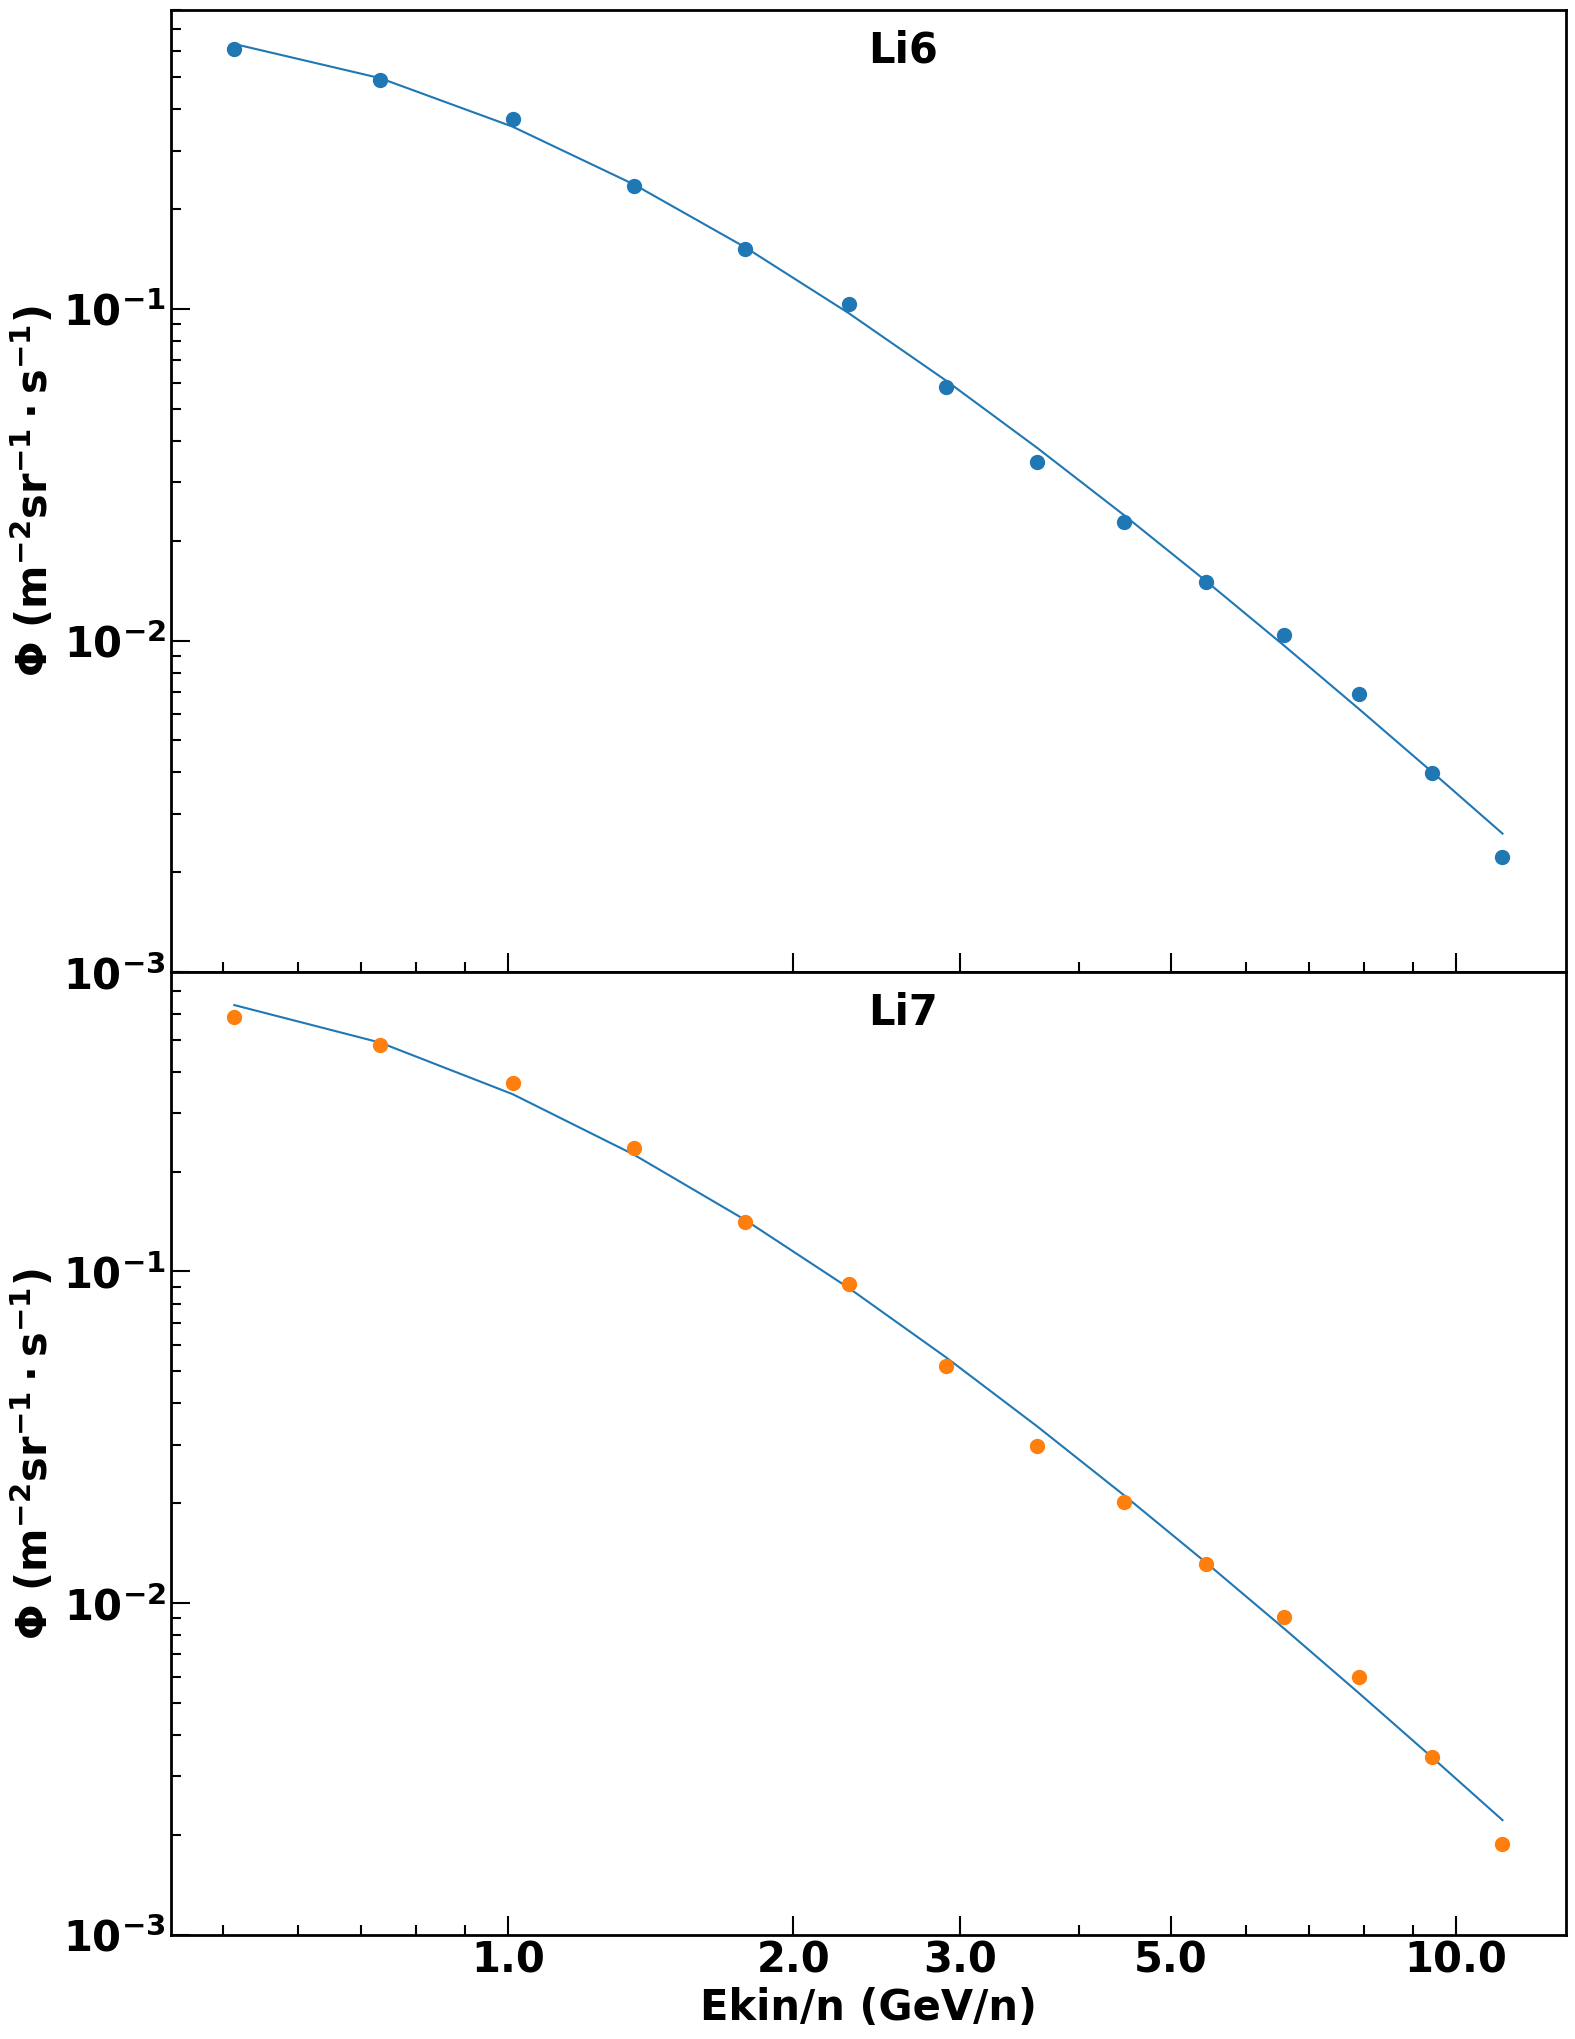

In [15]:
filename = '/home/manbing/Documents/lithiumanalysis/scripts/plots/isotopesflux/thismc/Be_Isoflux.npz'
data = np.load(f'{filename}')
plotdir = '/home/manbing/Documents/lithiumanalysis/scripts/plots/unfold/'
graph_flux = dict()
isoylim={'Li6': [0.001, 0.8], 'Li7':[0.001, 0.8]}
isoflux_powerlaw = dict()
isoflux_param_dict = dict()

guess_init = {'phi': 0.6481047734488288, 'c': 0.00910388990622317, 'rigidity_scale': 6.30008161547104, 'gamma': -2.793550533750972}
print(nuclei)
isoflux_powerlaw_dec = {dec: {} for dec in detectors}
isoflux_param_dict_dec = {dec: {} for dec in detectors}

for iso in ISOTOPES[nuclei]:
    refflux_array = np.core.records.fromarrays((graph_rawflux_combined[iso].xvalues, graph_rawflux_combined[iso].yvalues, graph_rawflux_combined[iso].yerrs, graph_rawflux_combined[iso].yerrs), names=("rigidity", "flux", "flux_error_low", "flux_error_high"))
    isoflux_powerlaw[iso], isoflux_param_dict[iso]  = fit_flux(refflux_array,  "{iso}flux", function=power_law, guess=guess_init)
    print(isoflux_powerlaw[iso](graph_rawflux_combined[iso].xvalues))
    

for dec in detectors:
    refflux_array = np.core.records.fromarrays((graph_rawflux[dec]['Li6'].xvalues, graph_rawflux[dec]['Li6'].yvalues, graph_rawflux[dec]['Li6'].yerrs, graph_rawflux[dec]['Li6'].yerrs), names=("rigidity", "flux", "flux_error_low", "flux_error_high"))
    isoflux_powerlaw_dec[dec], isoflux_param_dict_dec[dec] = fit_flux(refflux_array,  "{iso}flux", function=power_law, guess=guess_init)
    print(isoflux_param_dict_dec[dec])

fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios':[0.5, 0.5]}, figsize=(18, 25))
ax = [ax1, ax2]
for i, iso in enumerate(ISOTOPES[nuclei]):
    ax[i].text(0.5, 0.98, f"{iso}", fontsize=FONTSIZE, verticalalignment='top', horizontalalignment='left', transform=ax[i].transAxes, color="black", fontweight="bold")
    ax[i].set_ylabel(r"$\mathrm{\Phi \ (m^{-2} sr^{-1} \cdot s^{-1})}$")   
    plot_graph(fig, ax[i], graph_rawflux_combined[iso], color=ISOTOPES_COLOR[iso], style="EP", xlog=True, ylog=True, markersize=20)
    ax[i].set_ylim(isoylim[iso])    
    ax[i].plot(graph_rawflux_combined[iso].xvalues, isoflux_powerlaw[iso](graph_rawflux_combined[iso].xvalues), '-')
    
ax2.set_xlabel("Ekin/n (GeV/n)")     
ax2.set_xticks([0.4, 1, 2, 3, 5, 10])                                                                                                                                                                      
ax2.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())                                                                                                                                   
ax1.sharex(ax2)   


ax1.get_xticklabels()[0].set_visible(False)   

set_plot_defaultstyle(ax1)                                                                                                                                                                                 
set_plot_defaultstyle(ax2)   
plt.subplots_adjust(hspace=.0)
savefig_tofile(fig, plotdir, f'{nuclei}_isoflux', 1)



KeyError: 'Li6'

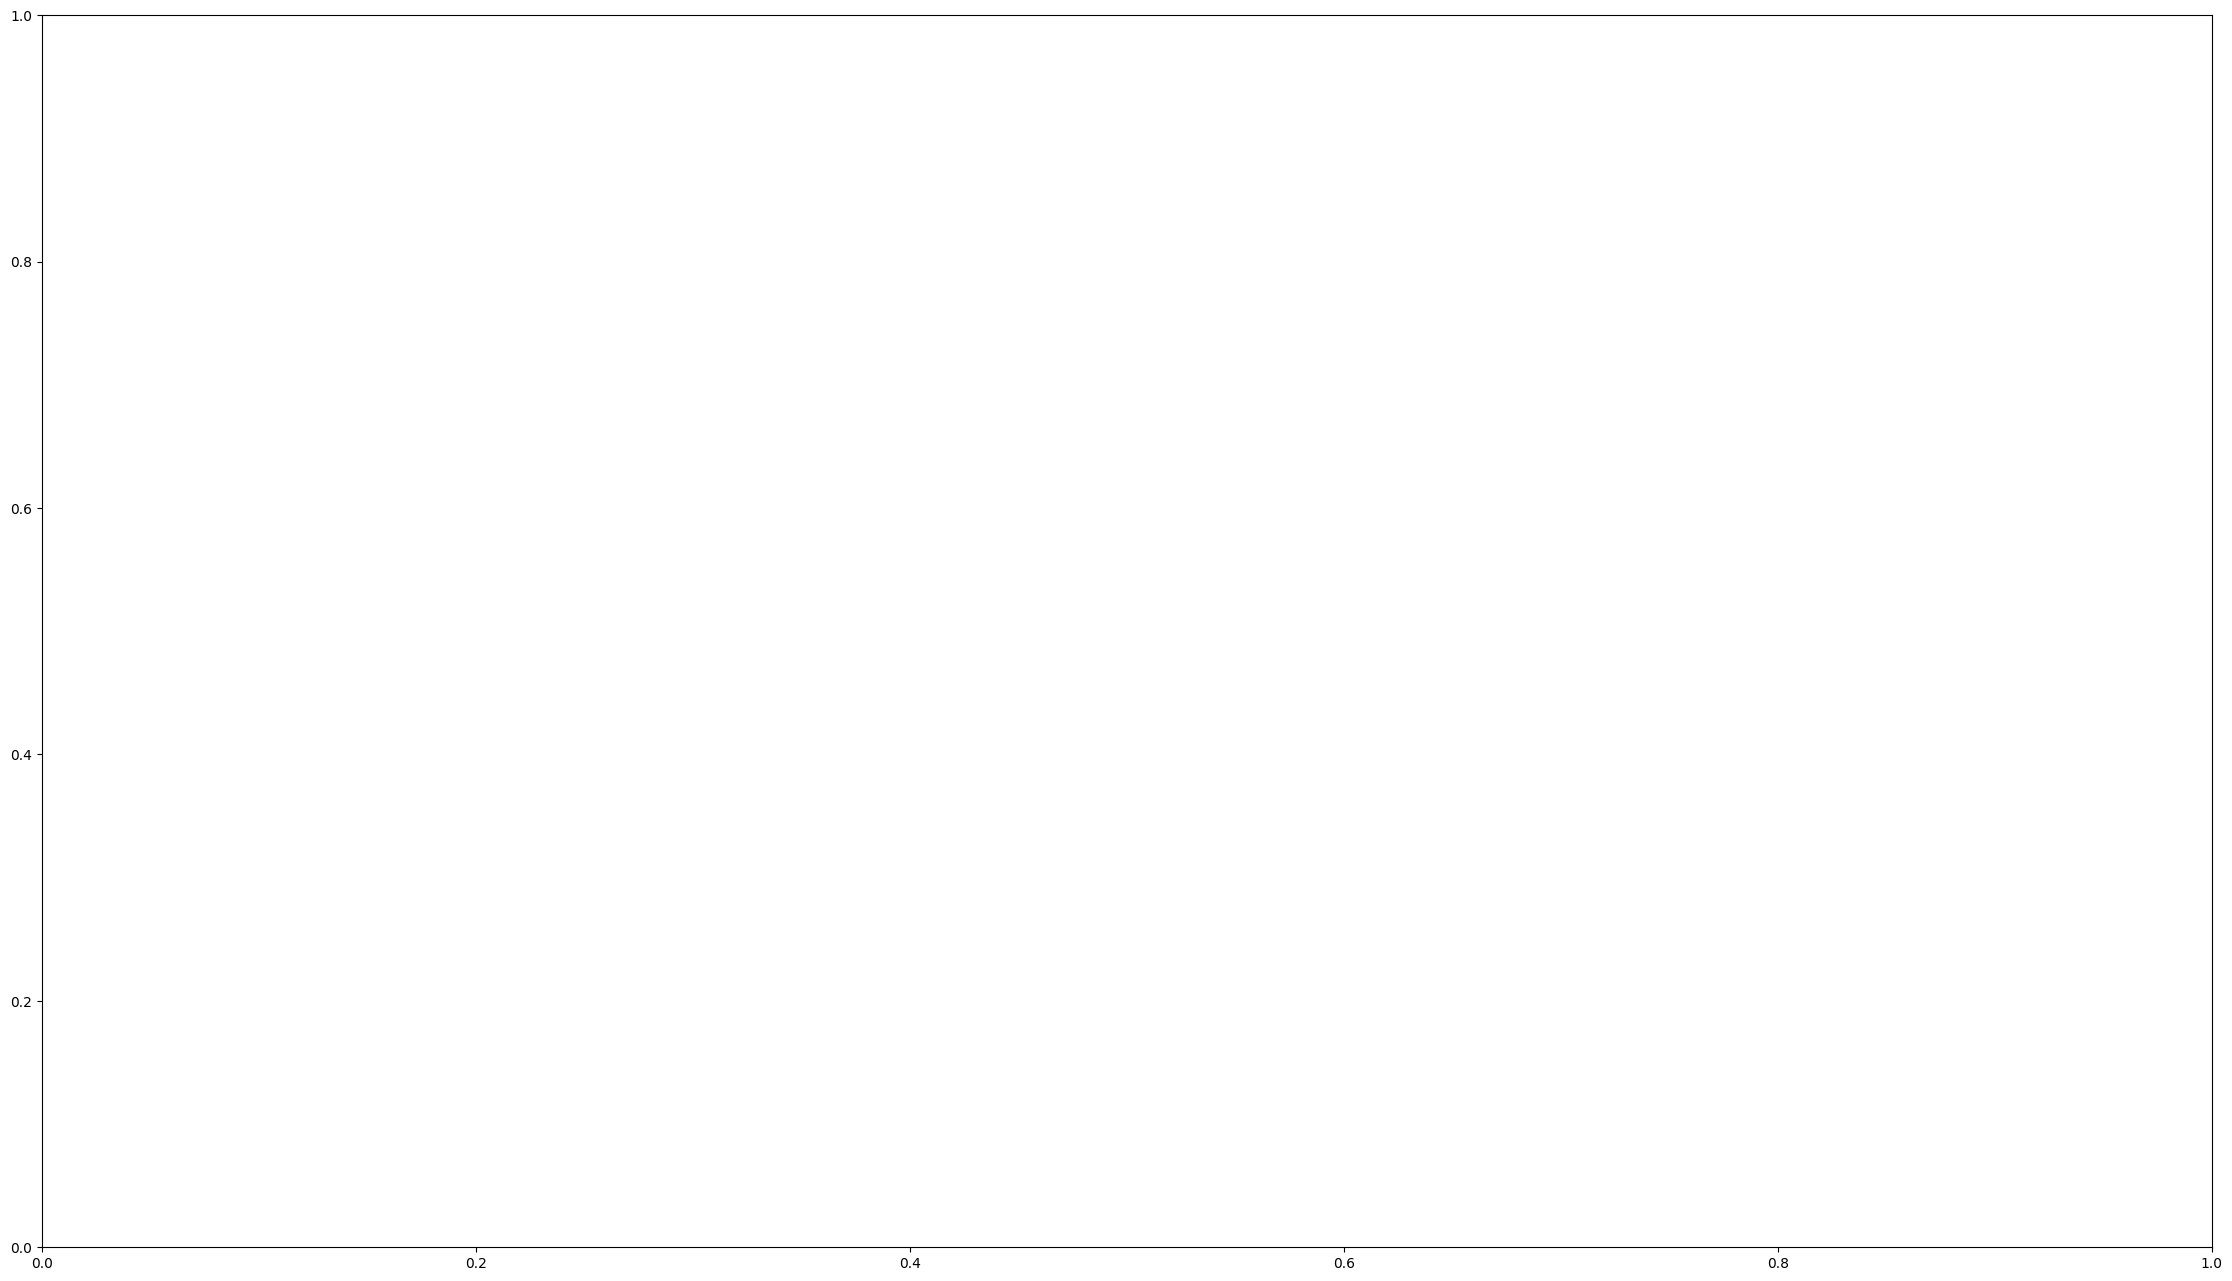

In [7]:
fig, ax1 = plt.subplots(figsize=(28, 16))
for iso in ISOTOPES[nuclei]:
    plot_graph(fig, ax1, graph_measured_rate_combined[iso], color=ISOTOPES_COLOR[iso], style="EP", xlog=True, ylog=False, markersize=20, label=f"{ISO_LABELS[iso]}")
    print(graph_measured_rate_combined[iso])
#plot_graph(fig, ax1, graph_predict_rate, color='black', style="EP", xlog=True, ylog=False, markersize=20, label=f"intergrate")
ax1.set_ylabel(r"$\mathrm{Counts/time \  (s^{-1}) }$", fontsize=35) 
ax1.set_xlabel(r"$\mathrm{E_{k}}$ per neucleon (GeV/n)", fontsize=35)     
ax1.set_xticks([0.4, 1, 2, 3, 5, 10])                                                                                                                                                                      
ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())  
set_plot_defaultstyle(ax1)   
#ax1.legend()
savefig_tofile(fig, plotdir, 'be_iso_measuredrate', 1)

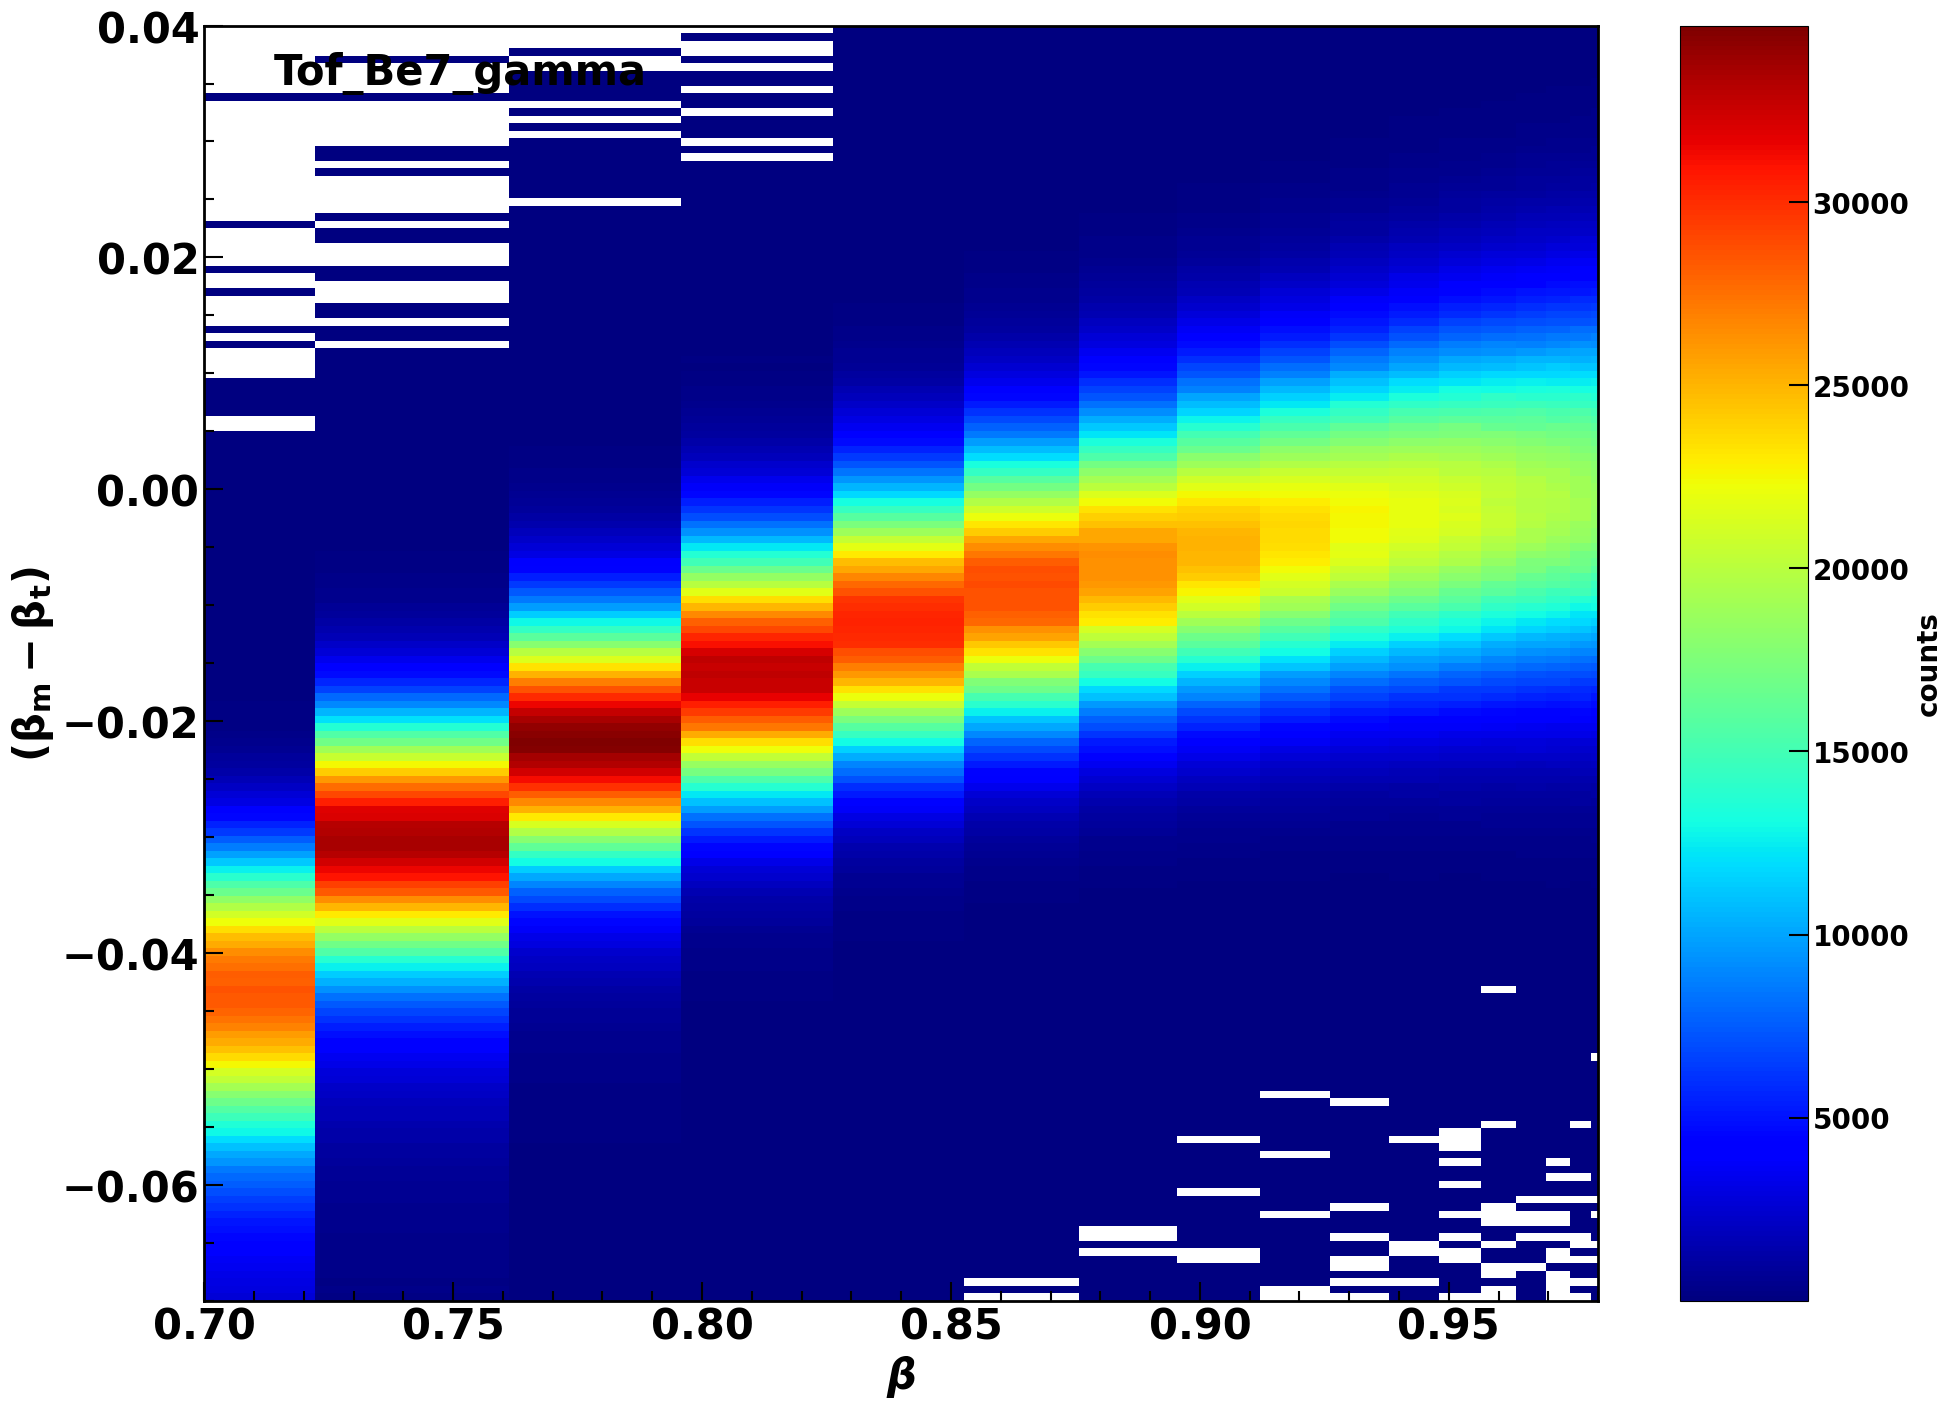

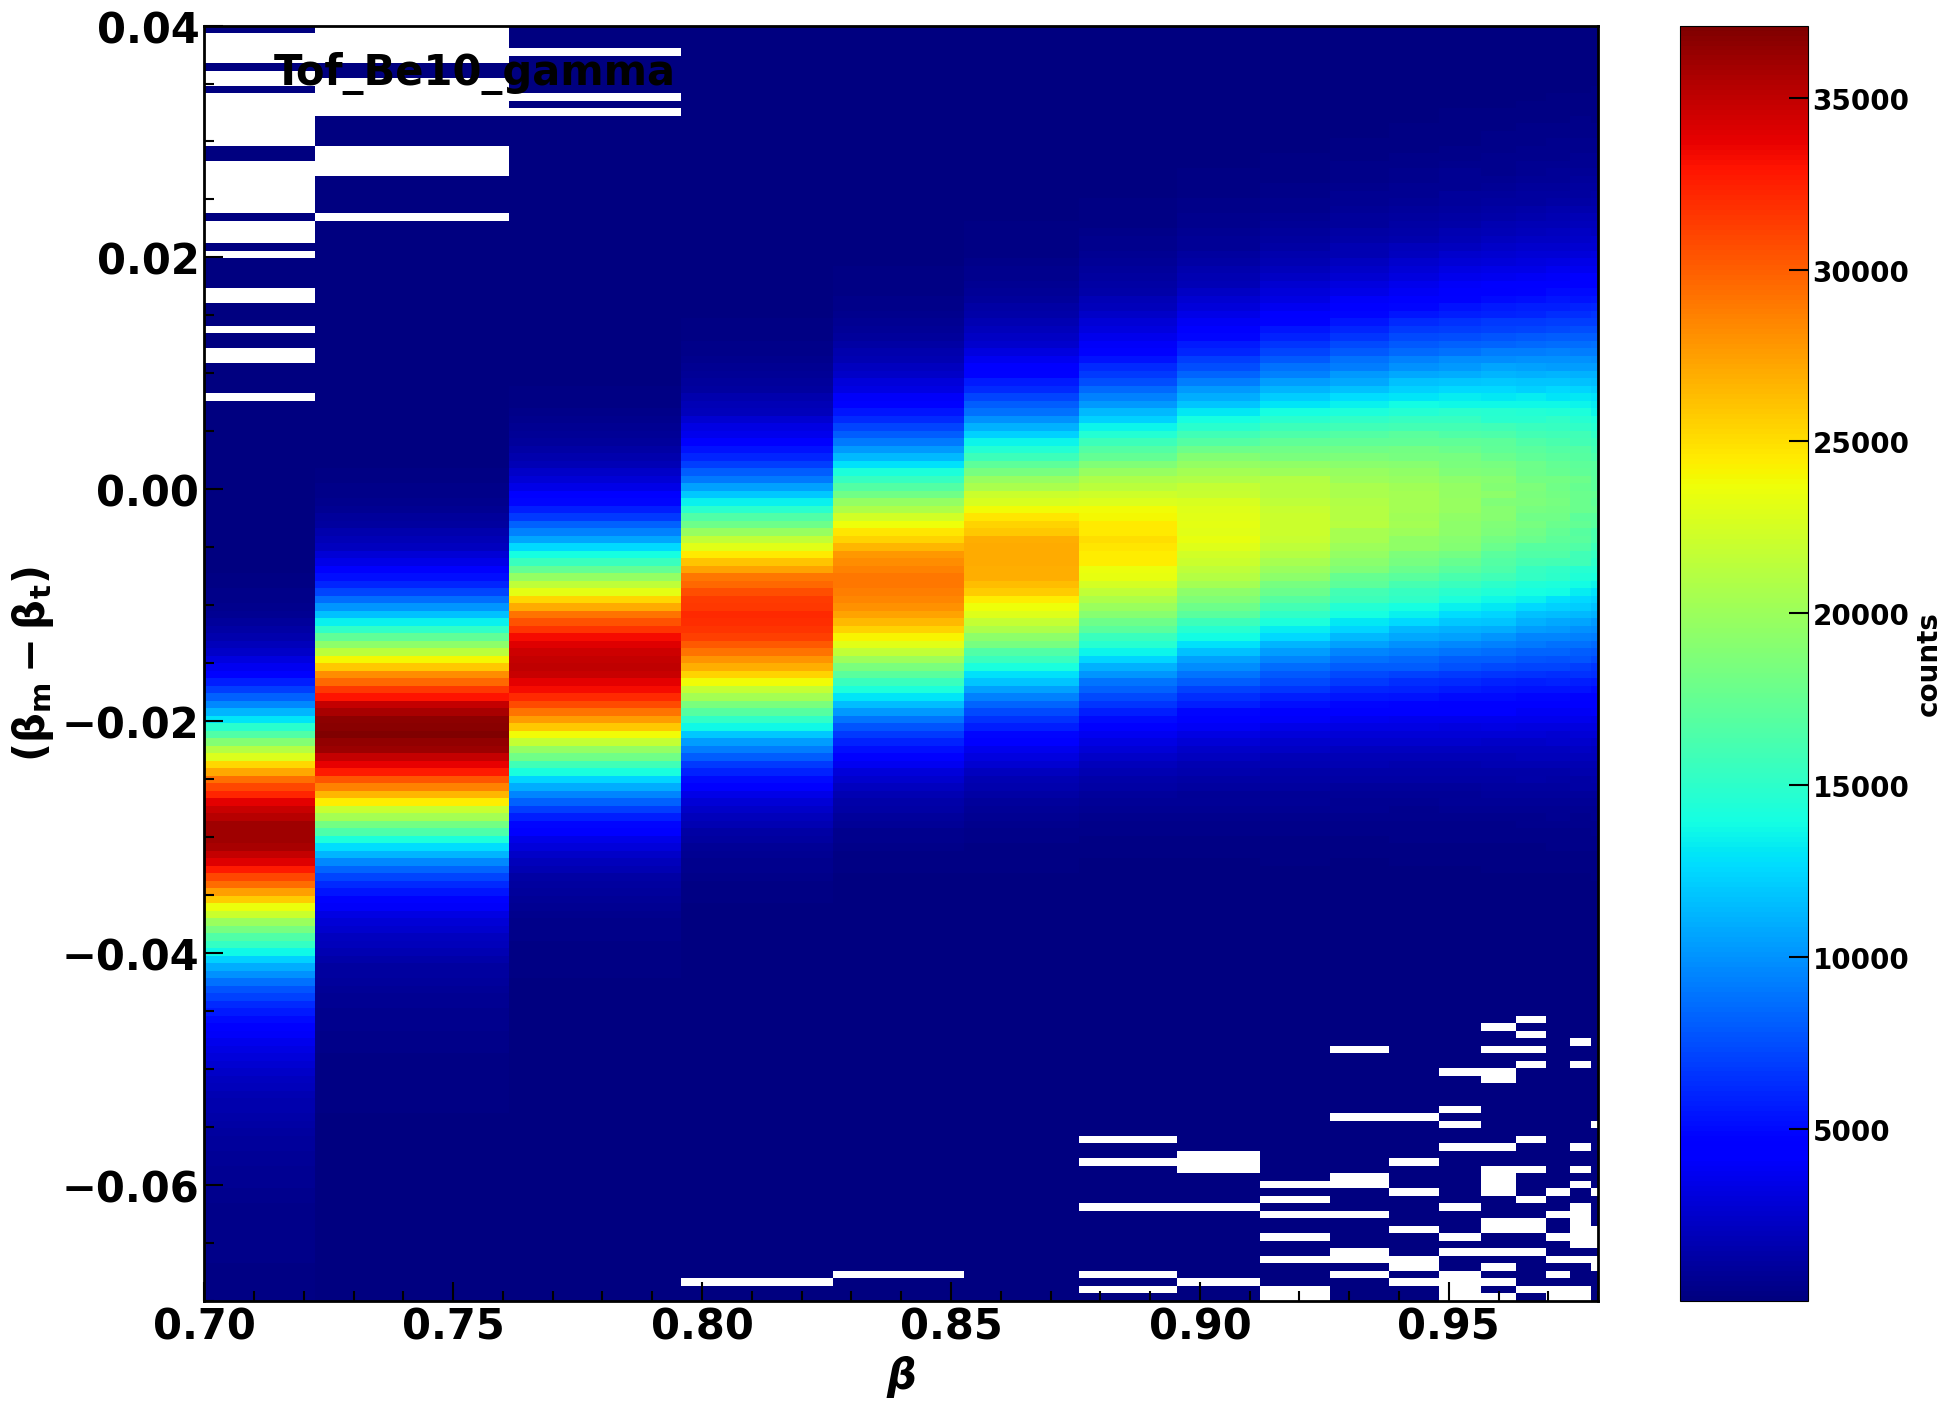

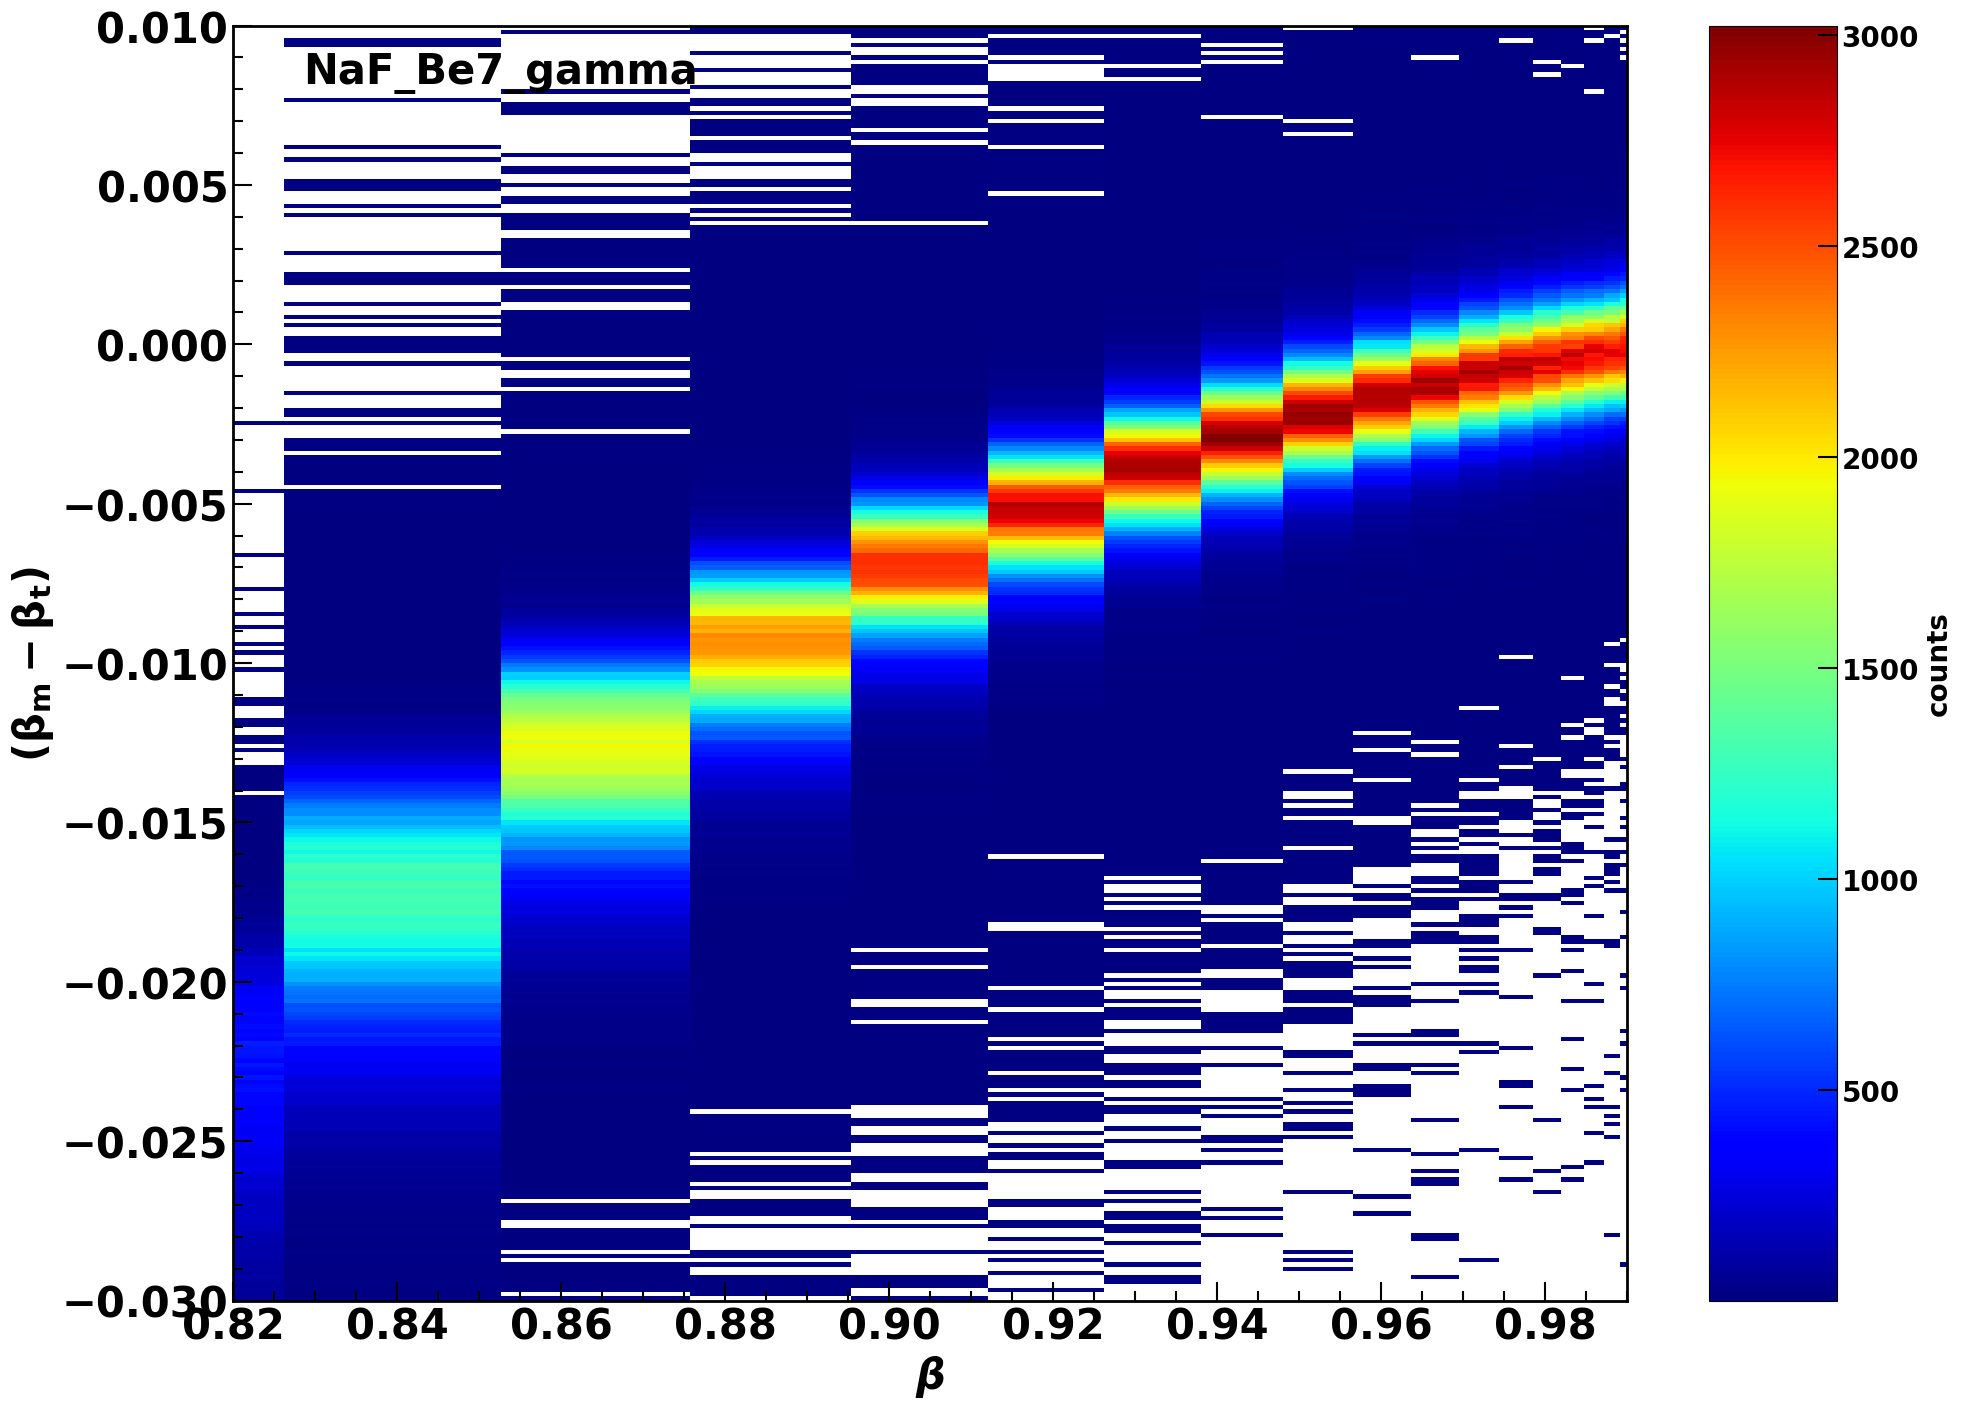

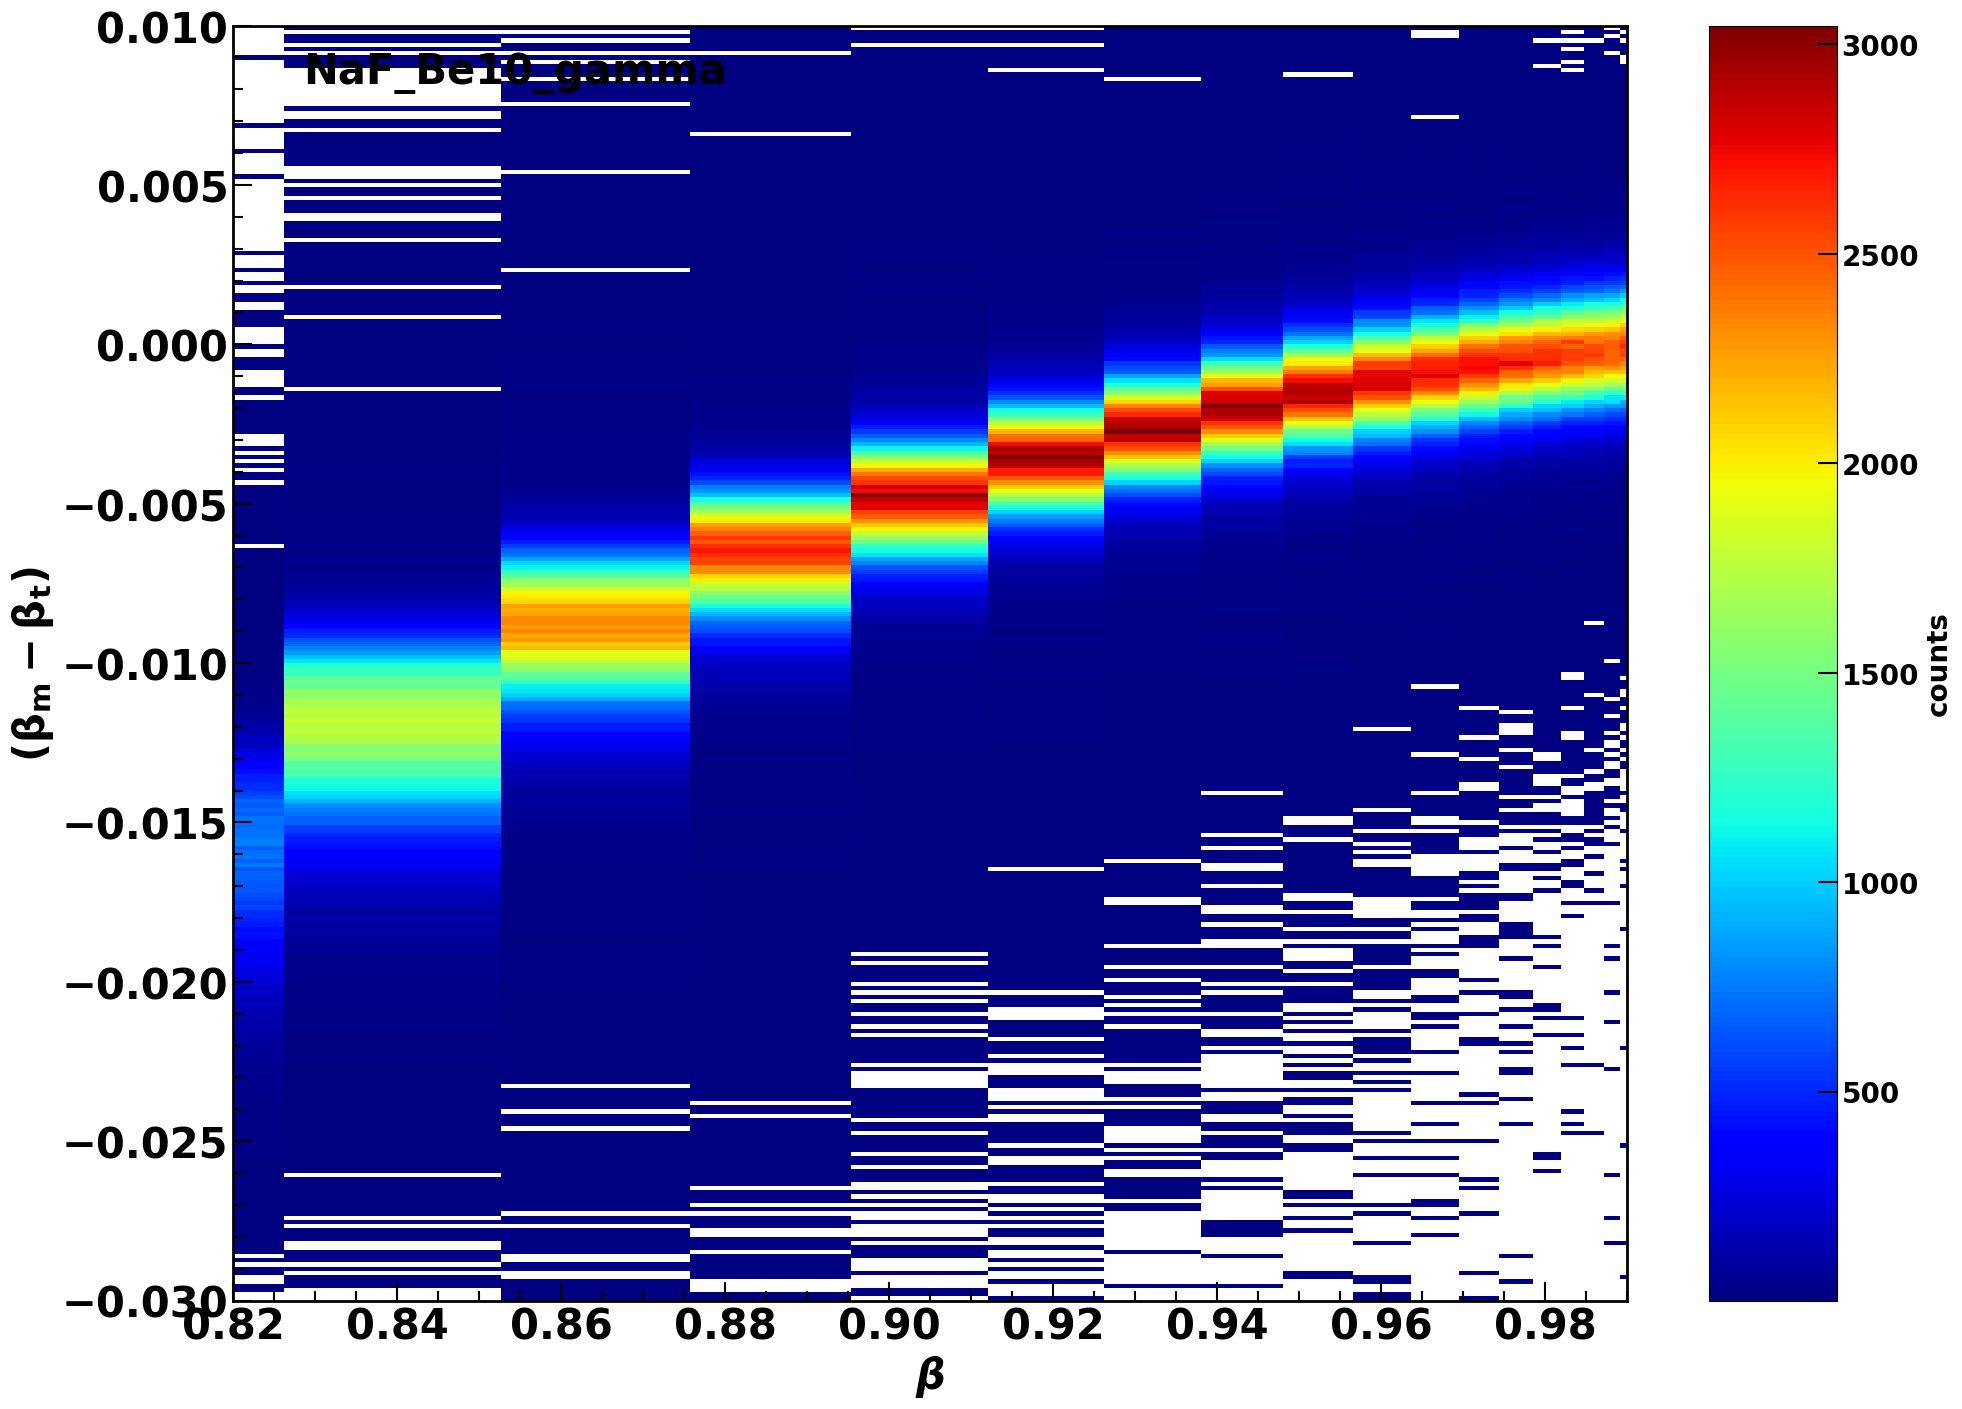

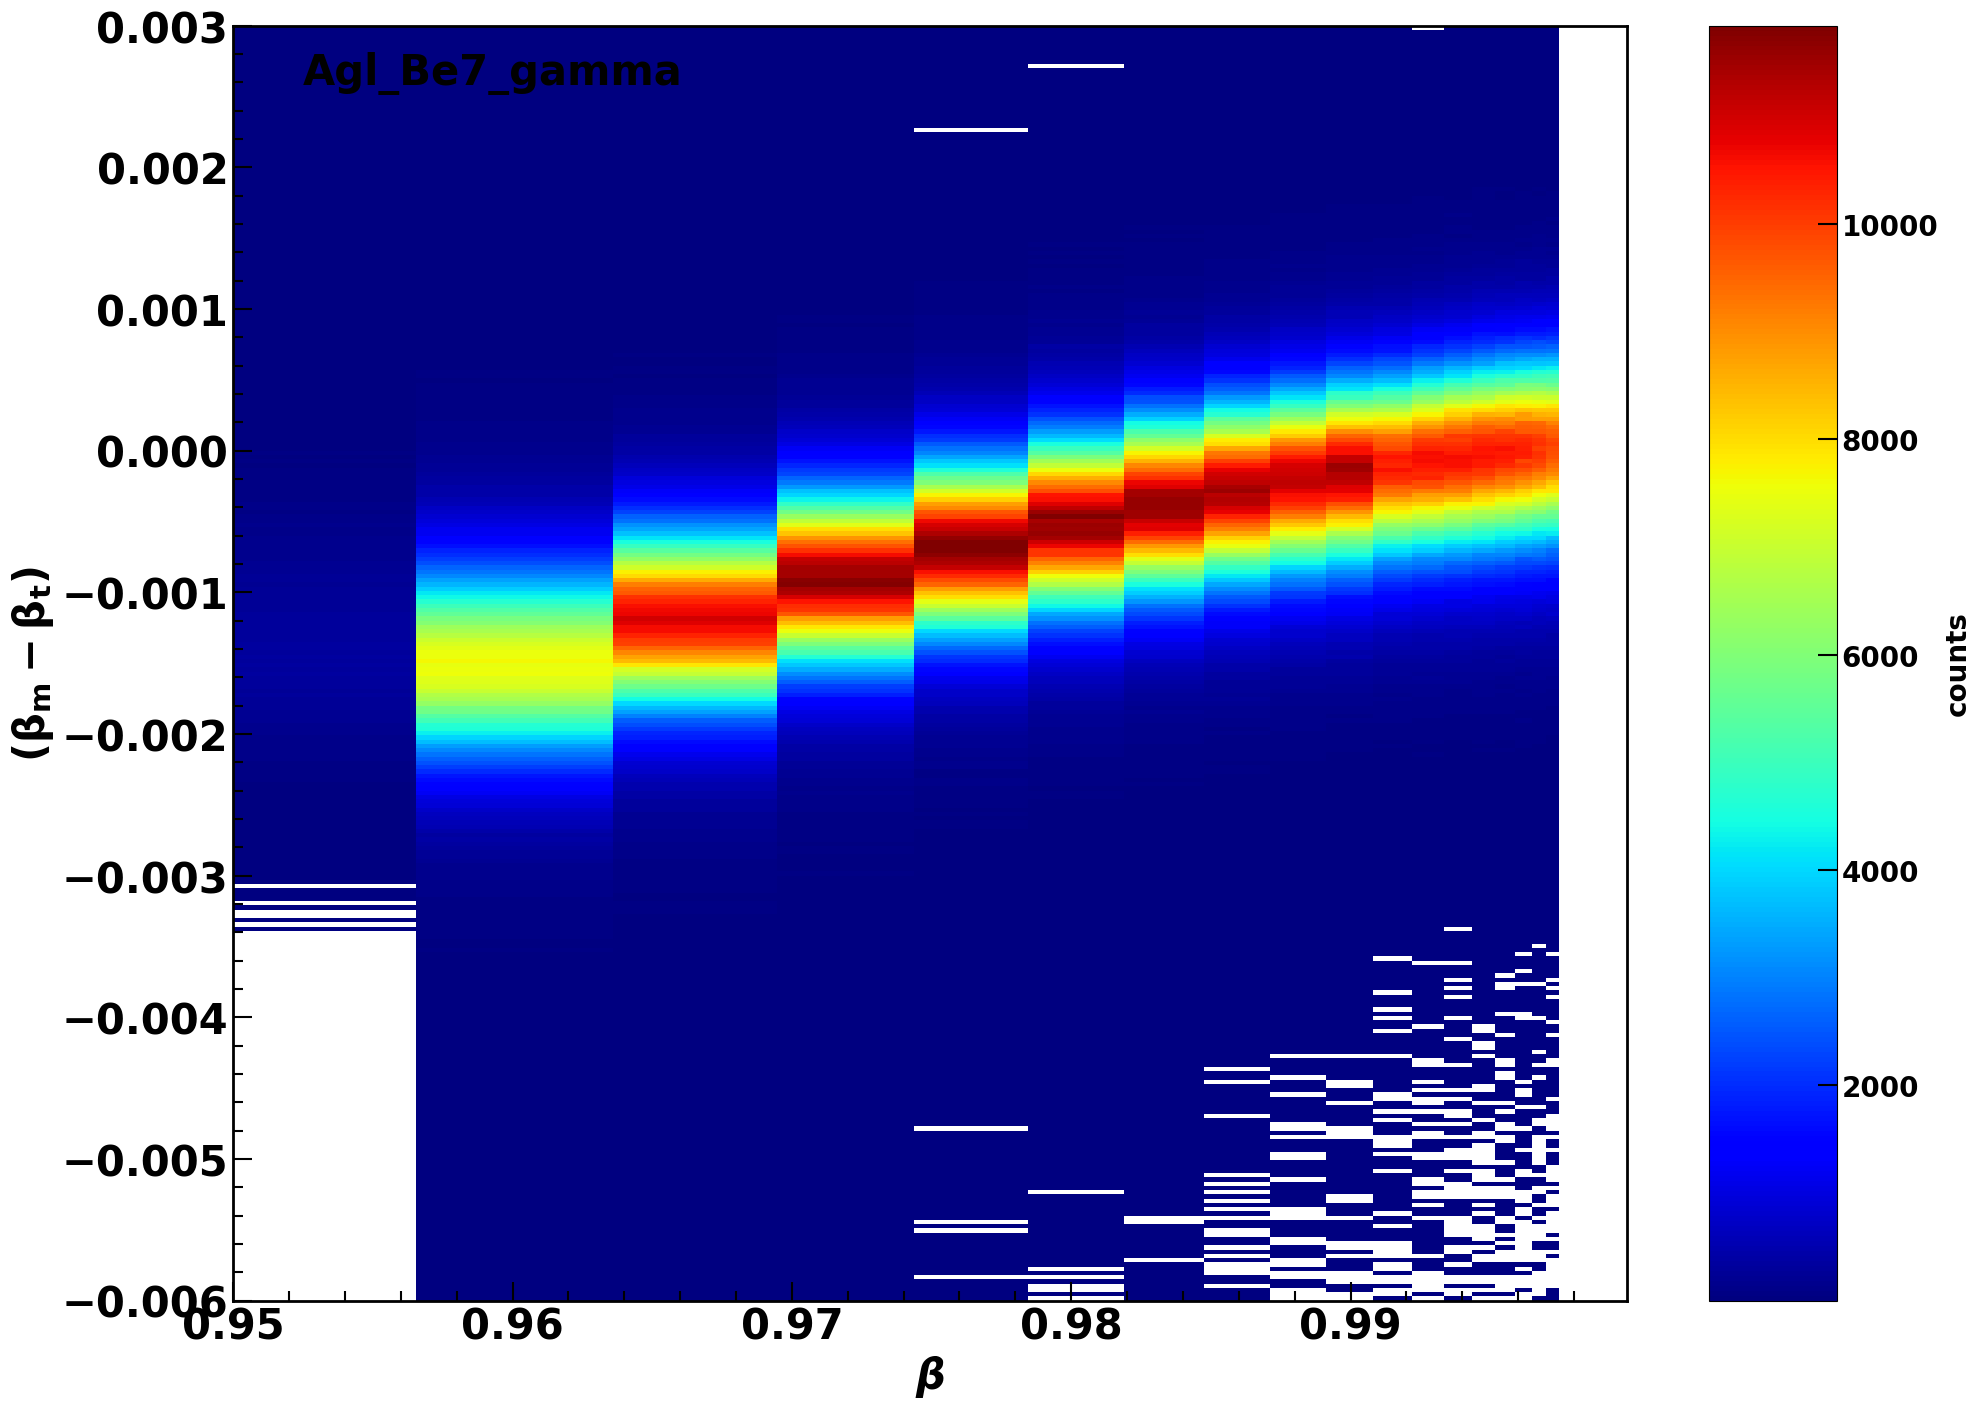

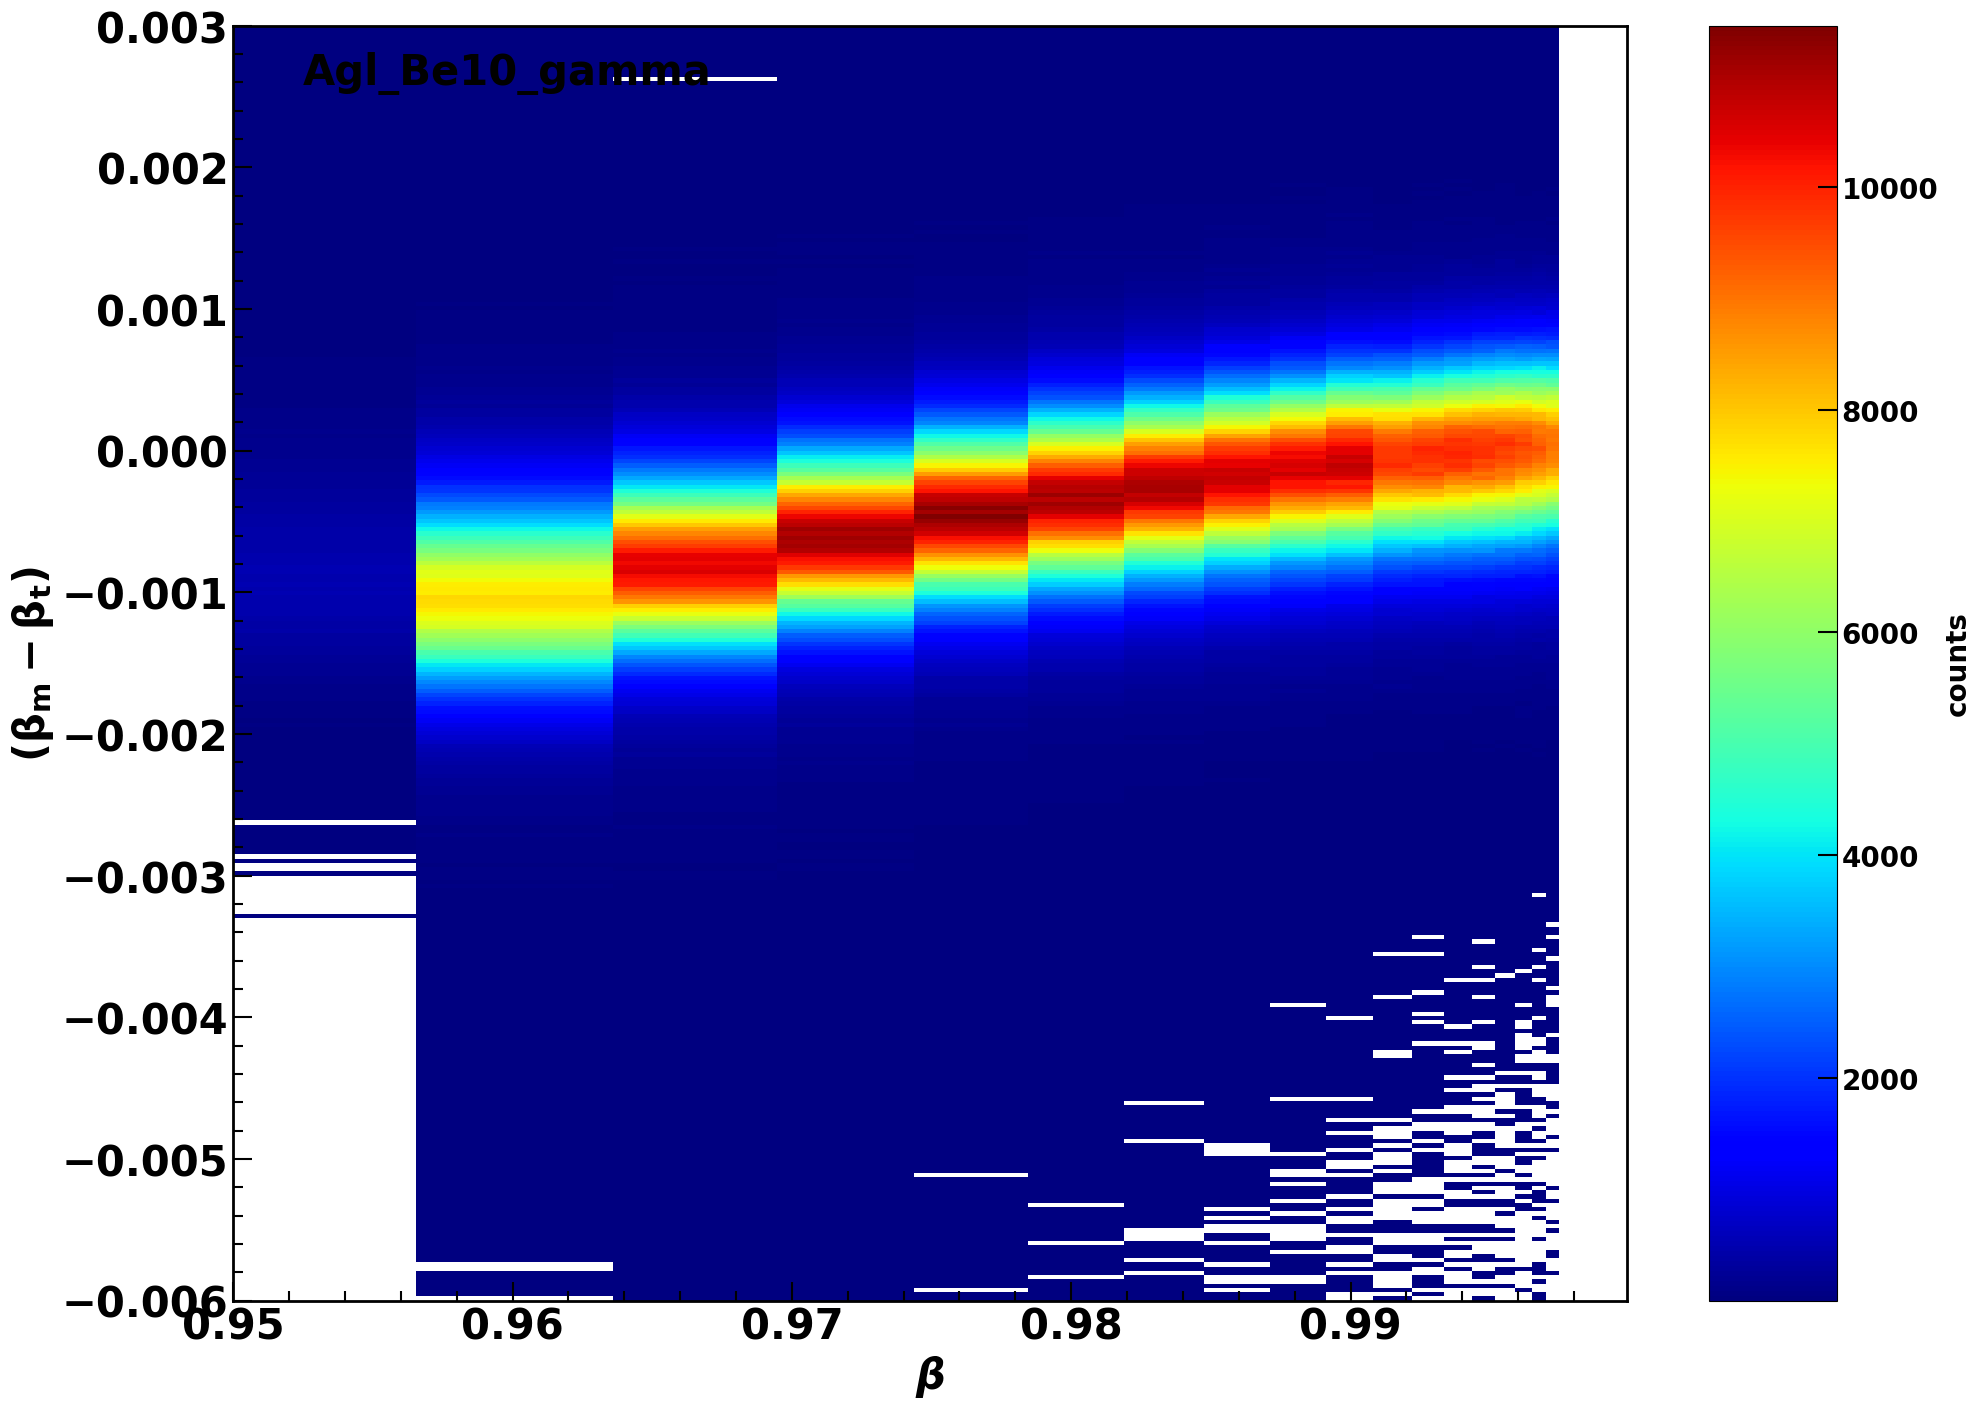

In [16]:
file_beta = '/home/manbing/Documents/Data/data_unfold/dfile/Be7MC_beta_resolution_rawrwth_v1.npz'
#file_beta = '/home/manbing/Documents/lithiumanalysis/scripts/plots/unfold/LiBeta/TofLi6_polypar_inversebeta.npz'
isotopes = ['Be7', 'Be10']
hist2d = {dec: {} for dec in detectors}
gammalim = {'Tof':[1.6, 5.0], "NaF":[2.0, 10.0], "Agl":[3.3, 15.0]}
beta_range = {"Tof": [0.7, 0.98], "NaF": [0.82, 0.99], "Agl": [0.95, 0.9999]} 
with np.load(file_beta) as npzfile:
    for dec in detectors:
        for iso in isotopes:
            hist2d[dec][iso] = WeightedHistogram.from_file(npzfile, f"hist2d_beta_residual_{dec}_{iso}")  
            fig = plt.figure(figsize=(20, 15))
            plot = fig.subplots(1, 1) 
            plot2dhist(fig, plot, xbinning=hist2d[dec][iso].binnings[0].edges[1:-1],
                       ybinning=hist2d[dec][iso].binnings[1].edges[1:-1],
                       counts=hist2d[dec][iso].values[1:-1, 1:-1], 
                       xlabel=None, ylabel=None, zlabel="counts", zmin=None, zmax=None, 
                       setlogx=False, setlogy=False, setscilabelx=False, setscilabely=False,  setlogz=False)  
            plot.text(0.05, 0.98, f"{dec}_{iso}_gamma", fontsize=FONTSIZE, verticalalignment='top', horizontalalignment='left', transform=plot.transAxes, color="black", fontweight="bold")          
            plot.set_xlabel(r"$\beta$", fontsize=30)                                                                                                                                                     
            plot.set_ylabel(r'$\mathrm{(\beta_{m}-\beta_{t})}$', fontsize=30)
            #plot.set_xscale('log')
            plot.set_xlim(beta_range[dec])
            savefig_tofile(fig, plotdir, f"hist2d_{dec}_{iso}", show=True)                                                                                                                 

#for ibin in range(28):
#    hist_ibin_gamma = hist2d['Agl']['Be7'].project(ibin)
#print(hist2d_gamma[dec][iso].binnings[0].edges[1:-1][22])
#fig = plt.figure(figsize=(20, 15))
#plot = fig.subplots(1, 1) 
#plot_histogram_1d(plot, hist_ibin_gamma, style="iss", color="black", label="data", scale=None, gamma=None, xlog=False, ylog=True, shade_errors=False)


Now I have the fit the resolutions and get the parameters. (reso_prob)
The following steps are :
1. write the function for the calculating the rate with (flux * acc * reso_prob)

In [17]:
### 
# x = beta_rec - beta_true 
from scipy import integrate
parnames = ['mean', 'sigma', 'sigma_ratio', 'asy_factor', 'fraccore']

def prob_resolution(x, mean, sigma, sigma_ratio, asy_factor, fraccore):                                                                                                                                                                      
    coregaus = gaussian(x, mean, sigma)                                                                                                                                                                                                           
    asygaus = asy_gaussian_1d(x, mean,  sigma_ratio * sigma, asy_factor)                                                                                                                                                                          
    pdf = (fraccore * coregaus + (1 - fraccore) * asygaus)                                                                                                                                                                                 
    return pdf 

#when transfer flux from ekin to beta, need the term dE/dBeta
def dEdbeta(beta):
    return mass_nucleon_gev * beta * (1-beta**2)**(-3/2)

def rate_func(b_true, b_rec, phi, c, rigidity_scale, gamma, spline_acc, df_probpars):
    flux = power_law(calc_ekin_from_beta(b_true), phi, c, rigidity_scale, gamma) * dEdbeta(b_true)
    fluxTimeAcc = flux * spline_acc(np.log(calc_ekin_from_beta(b_true))) 
    prob_par = dict()
    for par in parnames:
        prob_par[par] = np.poly1d(df_probpars[par])(np.log(b_true))
    #event_rate = fluxTimeAcc * prob_resolution(b_rec - b_true, prob_par['mean'], prob_par['sigma'], prob_par['sigma_ratio'],prob_par['fraccore'],prob_par['asy_factor'] )
    event_rate = fluxTimeAcc * prob_resolution(b_rec - b_true, **prob_par)
    return event_rate
    
    

integrate the rate function to get the prediction_rate in each beta bin 

In [18]:
def get_predict_rate(xbeta_binning, beta_range, flux_pars, spline_acc, resoprobpars):
    binrange = xbeta_binning.get_indices(beta_range) 
    xvalue_beta = xbeta_binning.bin_centers[binrange[0]: binrange[1]] 
    predict_rate = np.zeros_like(xvalue_beta)
    predict_rate_err = np.zeros_like(xvalue_beta)
    #print(xbeta_binning.edges)
    #print(xvalue_beta)
    prob_par = dict()
    mu = np.poly1d(resoprobpars['mean'])(np.log(xvalue_beta))
    sig = np.poly1d(resoprobpars['sigma'])(np.log(xvalue_beta))
    #print('mu:', mu)
    #print('sigma:', sig)
    for ip, ibin in enumerate(range(binrange[0], binrange[1])): 
        #print(ibin)
        #print('min:', min(ibin+3, len(xbeta_binning.edges)-2))
        ibeta = xbeta_binning.bin_centers[ibin]
        #print(ibeta)
        beta_true_intmin = xbeta_binning.edges[ibin]  -mu[ip] - 4* sig[ip] 
        beta_true_intmax = xbeta_binning.edges[ibin+1] -mu[ip] + 4* sig[ip] 
        #print(ibeta)
        #print('A:', beta_true_intmin,beta_true_intmax)
        #print('B:', xbeta_binning.edges[max(1, ibin-2)], xbeta_binning.edges[min(ibin+3, len(xbeta_binning.edges)-2)])
        if ip < 5:
            predict_rate[ip], predict_rate_err[ip] = integrate.nquad(rate_func, [[xbeta_binning.edges[max(1, ibin-2)], xbeta_binning.edges[min(ibin+3, len(xbeta_binning.edges)-2)]],[xbeta_binning.edges[ibin],xbeta_binning.edges[ibin+1]]], args=list(flux_pars)+[spline_acc, resoprobpars], opts=dict(epsrel=1e-3))
        else:
            predict_rate[ip], predict_rate_err[ip] = integrate.nquad(rate_func, [[beta_true_intmin, beta_true_intmax],[xbeta_binning.edges[ibin],xbeta_binning.edges[ibin+1]]], args=list(flux_pars)+[spline_acc, resoprobpars], opts=dict(epsrel=1e-3))
         
    return predict_rate


Minimization 

In [19]:
flux_parnames = ['phi', 'c', 'rigidity_scale', 'gamma']
class func_LeastSquares:
    def __init__(self, graph_measure_rate, xbeta_binning, beta_range, spline_acc, resoprobpars):                                                                                                                                                                                                       
        self.func_code = make_func_code([par for par in flux_parnames])  
        self.ygraph = graph_measure_rate
        self.yvector = graph_measure_rate.yvalues    
        self.yvector_err = graph_measure_rate.yerrs
        self.xbeta_binning = xbeta_binning
        self.beta_range = beta_range
        self.spline_acc = spline_acc
        self.resoprobpars = resoprobpars
        
    def __call__(self, *par):
        flux_pars = par
        predict_rate = get_predict_rate(self.xbeta_binning, self.beta_range, flux_pars, self.spline_acc, self.resoprobpars)
        chis = np.sum(((predict_rate - self.yvector)/self.yvector_err)**2)
        print(chis)
        return chis



In [20]:
def run_unfold_minimization(decname, isoname, graph_measured_rate, xbeta_binning, beta_range, spline_acc, guess, resoprobpars):
    lsq = func_LeastSquares(graph_measured_rate, xbeta_binning, beta_range, spline_acc, resoprobpars)                                                                                                                                                                          
    minuit = Minuit(lsq, **guess)                                                                                                                                                                                                             
    minuit.errordef = 1.0                                                                                                                                                                                                                     
    minuit.migrad()                                                                                                                                                                                                                           
    minuit.hesse()    
    print(minuit)
    print(minuit.values)
    mvalues = minuit.values
    merrs = minuit.errors
    return mvalues, merrs

def true_rate_func(b_true, phi, c, rigidity_scale, gamma, spline_acc):
    flux = power_law(calc_ekin_from_beta(b_true), phi, c, rigidity_scale, gamma) * dEdbeta(b_true)
    fluxTimeAcc = flux * spline_acc(np.log(calc_ekin_from_beta(b_true))) 
    event_rate = fluxTimeAcc 
    return event_rate

#get the true unfolded rate with the flux_pars got from the minimization
def get_unfold_rate(xbeta_binning, beta_range, flux_pars, spline_acc):
    binrange = xbeta_binning.get_indices(beta_range) 
    xvalue_beta = xbeta_binning.bin_centers[binrange[0]: binrange[1]] 
    unfold_rate = np.zeros_like(xvalue_beta)
    unfold_rate_err = np.zeros_like(xvalue_beta)
    for ip, ibin in enumerate(range(binrange[0], binrange[1])): 
        unfold_rate[ip], unfold_rate_err[ip] = integrate.quad(true_rate_func, xbeta_binning.edges[ibin], xbeta_binning.edges[ibin+1], args=tuple(list(flux_pars)+[spline_acc]), epsrel=1e-3)  
    return unfold_rate
    

In [21]:
RANGE_EKIN_PLUSONE = {"Tof": [0.42, 1.6], "NaF": [1.1, 4.2], "Agl": [4.2, 13]}
RANGE_BETA = {dec: calc_beta_from_ekin(np.array(RANGE_EKIN_PLUSONE[dec])) for dec in detectors}
#guess_flux_init = {'phi': 0.91, 'c': 7.89e-3, 'rigidity_scale': 7.89e-3, 'gamma': -3.070}
#guess_flux_init = {'phi': 0.6484788986052318, 'c': 0.007459063428695519, 'rigidity_scale': 7.013846850536838, 'gamma': -2.7565763250621}
#phi=0.278800797922473 c=0.006286432544825294 rigidity_scale=6.6331729117951825 gamma=-2.706994460316708>
guess_iter1 = {'Tof': {'phi':0.4316246, 'c':0.008258085, 'rigidity_scale':6.896825, 'gamma': -2.2884089690210385}}
guess_flux_init = {'phi': 0.46687, 'c': 0.011455, 'rigidity_scale': 6.918, 'gamma':-2.7}

#print(guess)
#prepare the measured_rate and guess for minimization
datadir = '/home/manbing/Documents/lithiumanalysis/scripts/plots/LiP8/unfold'
ANALYSIS_RANGE_EKIN_Li = {'Tof':[0.4, 1.2], 'NaF':[1.0, 4.0], 'Agl':[4.2, 12.1]}
def run_forward_unfold(decname, isotope, graph_measured_rate, xbeta_binning, spline_acc, guess, resoprobpars):
    graph_measured_rate = slice_graph_by_value(graph_measured_rate, ANALYSIS_RANGE_EKIN_Li[dec])
    print(graph_measured_rate)
    print(len(graph_measured_rate.xvalues))
    binrange_index = xbeta_binning.get_indices(RANGE_BETA[decname]) 
    print('######################################')
    print(f'unfolding for {decname}, {isotope}:')
    print('guess:', guess)
    print('Beta binning:', xbeta_binning.edges)
    print('Beta binning in Ekin:', calc_ekin_from_beta(xbeta_binning.edges))
    print('Beta range:', RANGE_BETA[decname])
    print('number of bins:', binrange_index[1] - binrange_index[0])
    print('bin_centers:', xbeta_binning.bin_centers[binrange_index[0]: binrange_index[1]])
    print('bin_centers_ekin:', calc_ekin_from_beta(xbeta_binning.bin_centers[binrange_index[0]: binrange_index[1]]))      
    mvalues, merr = run_unfold_minimization(decname, isotope, graph_measured_rate, xbeta_binning, RANGE_BETA[decname], spline_acc, guess, resoprobpars)
    print('#end minimization#')
    unfold_rate = get_unfold_rate(xbeta_binning, RANGE_BETA[decname], mvalues, spline_acc)
    predict_rate = get_predict_rate(xbeta_binning, RANGE_BETA[decname], mvalues, spline_acc, resoprobpars)
    ratio_raw_to_unfold = predict_rate/unfold_rate
    df_results = {'flux_pars':mvalues,
                'flux_pars_err': merr,
                'unfold_rate':unfold_rate,
                'predict_rate': predict_rate,
                'ratio_raw_to_unfold': ratio_raw_to_unfold}  
    np.savez(os.path.join(datadir, f'unfold_results_{decname}{isotope}_v10.npz'), **df_results)
    return df_results

        

In [32]:
mass_nucleon_gev = 0.9314941 #in GeV 
#read the resolution fit parameters
df_probbeta_pars = {dec: {} for dec in detectors}
for dec in detectors:
    for iso in ISOTOPES[nuclei]:
        df_probbeta_pars[dec][iso] = np.load(f'/home/manbing/Documents/lithiumanalysis/scripts/plots/unfold/LiBeta/{dec}{iso}_polypar_beta.npz')
       

def xbinning_energy():                                                                                                                                                                                                                            
    binning = np.array([0.338, 0.4185, 0.5077,0.6103,0.7264,0.8561,1.0045,1.1666,1.3476,1.5473,1.7659,2.0085,2.2753,2.5662,2.8812,                                                                                                                
                        3.2256,3.5996,4.0029,4.4413,4.9146,5.4229,5.9886,6.5553,7.1793,7.8608,8.5998,9.3963,10.2502,11.1616,12.1303, 13.6, 14.8, 16.0])                                                                                          
    return binning 

xbinning_energy_rebin = fbinning_energy_rebin()
xbeta_binning = Binning(calc_beta_from_ekin(xbinning_energy_rebin))     
print(xbeta_binning.edges)
for iso in ISOTOPES[nuclei]:
    mu = np.poly1d(df_probbeta_pars['Tof'][iso]['mean'])(np.log(xbeta_binning.bin_centers[1:-1]))
    
    graph_mu = MGraph(xbeta_binning.bin_centers[1:-1], mu, np.zeros_like(mu))
    #print(graph_mu)
    #print(iso, mu)
    sig = np.poly1d(df_probbeta_pars['Tof'][iso]['sigma'])(np.log(xbeta_binning.bin_centers[1:-1]))
    
    

[      -inf 0.72381066 0.79686118 0.85350287 0.89604088 0.9267068
 0.94848055 0.9638856  0.97457228 0.98202022 0.98722439 0.99089904
 0.99338328 0.99521296 0.99652407 0.99745389        inf]


In [75]:
dec = 'Tof'
isoes = ['Li6']
def xbinning_energy():                                                                                                                                                                                                                            
    binning = np.array([0.338, 0.4185, 0.5077,0.6103,0.7264,0.8561,1.0045,1.1666,1.3476,1.5473,1.7659,2.0085,2.2753,2.5662,2.8812,                                                                                                                
                        3.2256,3.5996,4.0029,4.4413,4.9146,5.4229,5.9886,6.5553,7.1793,7.8608,8.5998,9.3963,10.2502,11.1616,12.1303, 13.6, 14.8, 16.0])                                                                                          
    return binning 
xbeta_binning = Binning(calc_beta_from_ekin(fbinning_energy_rebin()))

unfold_Tof = dict()
for iso in isoes:
    print(graph_measured_rate[dec][iso])
    unfold_Tof[iso] = run_forward_unfold(dec, iso, graph_measured_rate[dec][iso], xbeta_binning, spline_subgraph_acc[dec][iso], isoflux_param_dict[iso], df_probbeta_pars[dec][iso])


xvalues			yvalues			yerrs
0.5144			0.008910261276383252			0.00013878331723167256
0.7332			0.009175192890224976			8.431880611689845e-05
1.01135			0.008749503286624867			7.606379878542736e-05
1.3569499999999999			0.007734539387366983			9.720831145493942e-05


xvalues			yvalues			yerrs
0.5144			0.008910261276383252			0.00013878331723167256
0.7332			0.009175192890224976			8.431880611689845e-05
1.01135			0.008749503286624867			7.606379878542736e-05
1.3569499999999999			0.007734539387366983			9.720831145493942e-05

4
######################################
unfolding for Tof, Li6:
guess: {'phi': 0.46687360172088477, 'c': 0.011455596515556417, 'rigidity_scale': 6.961865306604942, 'gamma': -2.7058103699631393}
Beta binning: [      -inf 0.72381066 0.79686118 0.85350287 0.89604088 0.9267068
 0.94848055 0.9638856  0.97457228 0.98202022 0.98722439 0.99089904
 0.99338328 0.99521296 0.99652407 0.99745389        inf]
Beta binning in Ekin: [ 0.      0.4185  0.6103  0.8561  1.1666  1.5473  2.0085  2.566

In [76]:
print(unfold_Tof['Li6'])


{'flux_pars': <ValueView phi=0.3144482042169567 c=0.017300123175439164 rigidity_scale=8.455285326498865 gamma=-1.970061391769848>, 'flux_pars_err': <ErrorView phi=0.012864966773387387 c=0.0010954236553914335 rigidity_scale=0.27175520456135405 gamma=0.03660665671948175>, 'unfold_rate': array([0.009487  , 0.00967977, 0.00904549, 0.00792191]), 'predict_rate': array([0.00888793, 0.0092    , 0.0087271 , 0.00774895]), 'ratio_raw_to_unfold': array([0.93685383, 0.95043655, 0.96480111, 0.97816626])}


In [ ]:
dec = 'Tof'
isoes = ['Li6', 'Li7']
def xbinning_energy():                                                                                                                                                                                                                            
    binning = np.array([0.338, 0.4185, 0.5077,0.6103,0.7264,0.8561,1.0045,1.1666,1.3476,1.5473,1.7659,2.0085,2.2753,2.5662,2.8812,                                                                                                                
                        3.2256,3.5996,4.0029,4.4413,4.9146,5.4229,5.9886,6.5553,7.1793,7.8608,8.5998,9.3963,10.2502,11.1616,12.1303, 13.6, 14.8, 16.0])                                                                                          
    return binning 
xbeta_binning = Binning(calc_beta_from_ekin(xbinning_energy()))

unfold_Tof = dict()
for iso in isoes:
    unfold_Tof[iso] = run_forward_unfold(dec, iso, graph_measured_rate[dec][iso], xbeta_binning, spline_subgraph_acc[dec][iso], isoflux_param_dict[iso], df_probbeta_pars[dec][iso])

In [1]:
guessinit = {'phi': 5.332007809395435, 'c': 0.0347734995302351, 'rigidity_scale': 11.873529669090122, 'gamma': -5.855470934361578}

isoes = ['Li6']

xbeta_binning = Binning(calc_beta_from_ekin(fbinning_energy_rebin()))
unfold_Agl = dict()

for iso  in isoes:
    unfold_Agl[iso] = run_forward_unfold(dec, iso, graph_measured_rate[dec][iso], xbeta_binning, spline_subgraph_acc[dec][iso], guessinit, df_probbeta_pars[dec][iso])

NameError: name 'Binning' is not defined

In [ ]:
def xbinning_energy():                                                                                                                                                                                                                            
    binning = np.array([0.338, 0.4185, 0.5077,0.6103,0.7264,0.8561,1.0045,1.1666,1.3476,1.5473,1.7659,2.0085,2.2753,2.5662,2.8812,                                                                                                                
                        3.2256,3.5996,4.0029,4.4413,4.9146,5.4229,5.9886,6.5553,7.1793,7.8608,8.5998,9.3963,10.2502,11.1616,12.1303, 13.6, 14.8, 16.0])                                                                                          
    return binning 
dec = 'NaF'
iso = 'Li6'
xbeta_binning = Binning(calc_beta_from_ekin(fbinning_energy_rebin()))
unfold_NaFbe7 = run_forward_unfold(dec, iso, graph_measured_rate[dec][iso], xbeta_binning, spline_subgraph_acc[dec][iso], guess_flux_init, df_probpars[dec])

In [81]:
dec = 'NaF'
isoes = ['Li6']
def xbinning_energy():                                                                                                                                                                                                                            
    binning = np.array([0.338, 0.4185, 0.5077,0.6103,0.7264,0.8561,1.0045,1.1666,1.3476,1.5473,1.7659,2.0085,2.2753,2.5662,2.8812,                                                                                                                
                        3.2256,3.5996,4.0029,4.4413,4.9146,5.4229,5.9886,6.5553,7.1793,7.8608,8.5998,9.3963,10.2502,11.1616,12.1303, 13.6, 14.8, 16.0])                                                                                          
    return binning 
xbeta_binning = Binning(calc_beta_from_ekin(fbinning_energy_rebin()))
unfold_NaF= dict()

print(list(spline_subgraph_acc['NaF'].keys()))
print(list(graph_measured_rate['NaF'].keys()))

print(list(df_probbeta_pars['NaF'].keys()))
for iso  in isoes:
    print(iso)
    unfold_NaF[iso] = run_forward_unfold(dec, iso, graph_measured_rate[dec][iso], xbeta_binning, spline_subgraph_acc[dec][iso], isoflux_param_dict[iso], df_probbeta_pars[dec][iso])

['Li6', 'Li7']
['Li6', 'Li7']
['Li6', 'Li7']
Li6

xvalues			yvalues			yerrs
1.01135			0.0005951327142575028			1.096072235019895e-05
1.3569499999999999			0.0005264561369626961			6.367437381648008e-06
1.7779			0.0004121918389637764			4.484788001825009e-06
2.28735			0.00034162534754429393			3.680855558057201e-06
2.8959			0.0002281562049358752			2.6184692421058686e-06
3.61425			0.0001612760996027633			2.239100520240622e-06

6
######################################
unfolding for NaF, Li6:
guess: {'phi': 0.46687360172088477, 'c': 0.011455596515556417, 'rigidity_scale': 6.961865306604942, 'gamma': -2.7058103699631393}
Beta binning: [      -inf 0.72381066 0.79686118 0.85350287 0.89604088 0.9267068
 0.94848055 0.9638856  0.97457228 0.98202022 0.98722439 0.99089904
 0.99338328 0.99521296 0.99652407 0.99745389        inf]
Beta binning in Ekin: [ 0.      0.4185  0.6103  0.8561  1.1666  1.5473  2.0085  2.5662  3.2256
  4.0029  4.9146  5.9886  7.1793  8.5998 10.2502 12.1303  0.    ]
Beta range: [0.8

In [ ]:
dec = 'Tof'
iso = 'Be7'
def xbinning_energy():                                                                                                                                                                                                                            
    binning = np.array([0.338, 0.4185, 0.5077,0.6103,0.7264,0.8561,1.0045,1.1666,1.3476,1.5473,1.7659,2.0085,2.2753,2.5662,2.8812,                                                                                                                
                        3.2256,3.5996,4.0029,4.4413,4.9146,5.4229,5.9886,6.5553,7.1793,7.8608,8.5998,9.3963,10.2502,11.1616,12.1303, 13.6, 14.8, 16.0])                                                                                          
    return binning 
xbeta_binning = Binning(calc_beta_from_ekin(xbinning_energy()))
unfold_Tofbe7 = run_forward_unfold(dec, iso, graph_measured_rate[dec][iso], xbeta_binning, spline_subgraph_acc[dec][iso], guess_flux_init, df_probpars[dec])

In [22]:
unfold_results_NaFBe7 = np.load('/home/manbing/Documents/lithiumanalysis/scripts/plots/LiP8/unfold/unfold_results_NaFLi6_v0.npz')
print(list(unfold_results_NaFBe7.keys()))

unfold_results_AglBe7 = np.load('/home/manbing/Documents/lithiumanalysis/scripts/plots/LiP8/unfold/unfold_results_AglLi6_v10.npz')
print(list(unfold_results_AglBe7.keys()))

unfold_results_TofBe7 = np.load('/home/manbing/Documents/lithiumanalysis/scripts/plots/LiP8/unfold/unfold_results_TofLi6_v0.npz')
print(list(unfold_results_TofBe7.keys()))

unfold_results_Be7 = {'Tof': unfold_results_TofBe7, 'NaF': unfold_results_NaFBe7, 'Agl':unfold_results_AglBe7}

['flux_pars', 'flux_pars_err', 'unfold_rate', 'predict_rate', 'ratio_raw_to_unfold']
['flux_pars', 'flux_pars_err', 'unfold_rate', 'predict_rate', 'ratio_raw_to_unfold']
['flux_pars', 'flux_pars_err', 'unfold_rate', 'predict_rate', 'ratio_raw_to_unfold']



xvalues			yvalues			yerrs
0.5144			1.067402376917724			0.0
0.7332			1.0521480851931122			0.0
1.01135			1.0364830528229445			0.0
1.3569499999999999			1.022321097994834			0.0

[1.015895 1.01291  1.009925 1.00893  1.00694  1.007935]

xvalues			yvalues			yerrs
0.5144			1.080211205440737			0.0
0.7332			1.0647738622154295			0.0
1.01135			1.0489208494568198			0.0
1.3569499999999999			1.04182432715291			0.0
1.7779			1.0352034932879326			0.0
2.28735			1.0294165499805812			0.0
2.8959			1.0250994073021082			0.0
3.61425			1.0230345290923004			0.0
4.45875			1.015895			0.0
5.4516			1.01291			0.0
6.58395			1.009925			0.0
7.88955			1.00893			0.0
9.425			1.00694			0.0
11.190249999999999			1.0079349999999998			0.0

/home/manbing/Documents/lithiumanalysis/scripts/plots/unfold/


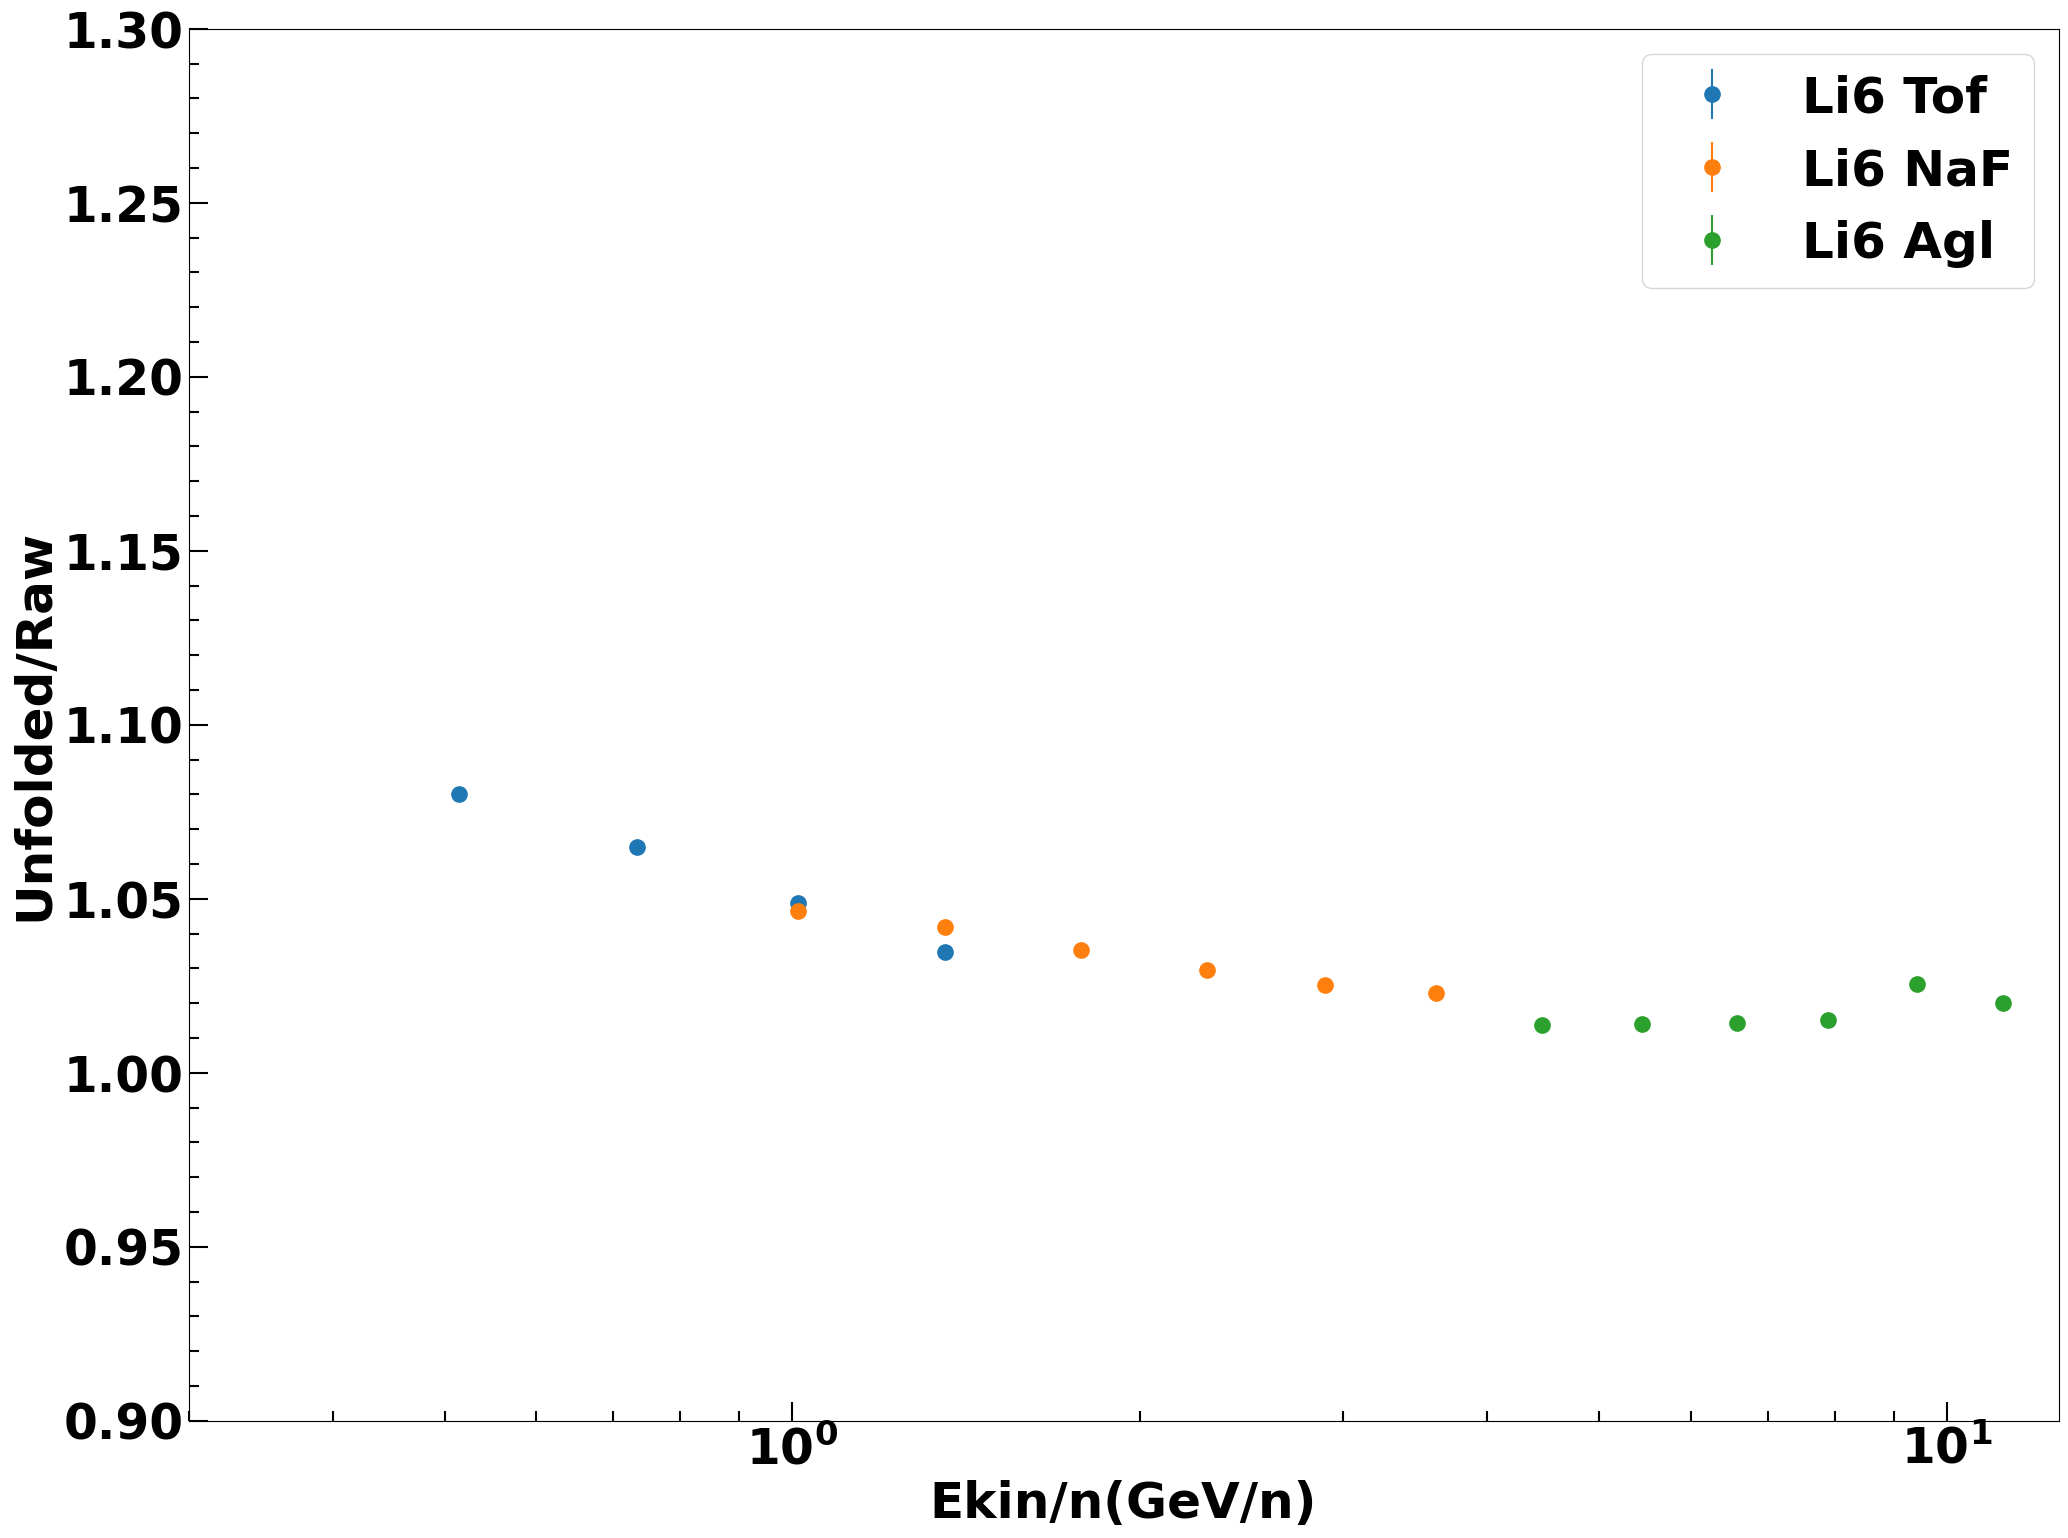

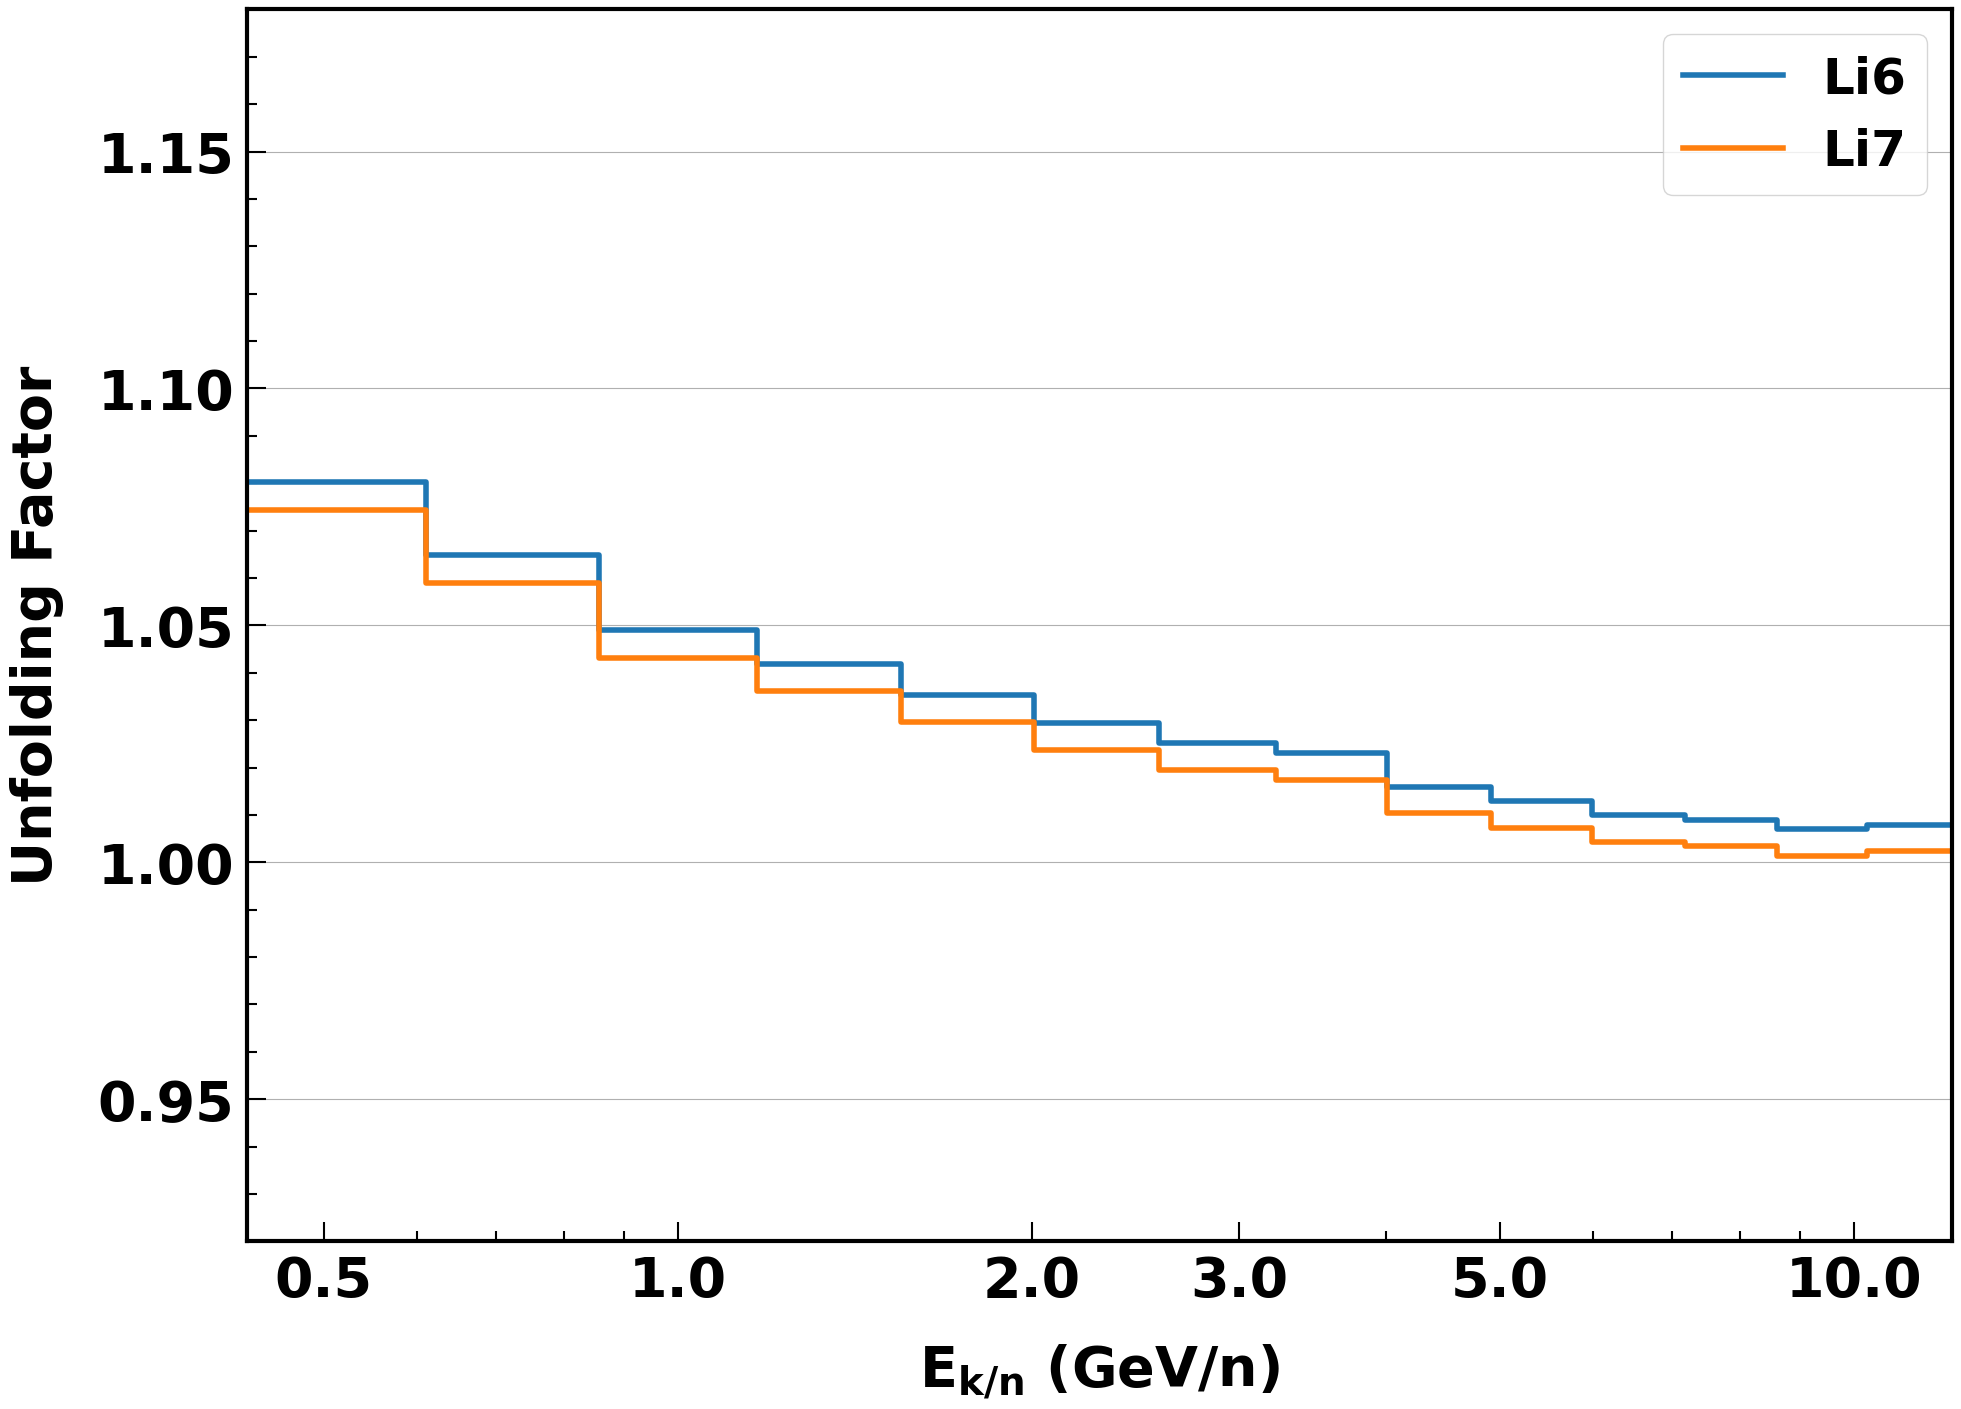

In [27]:
from tools.jupytertools import *
graph_unflod_factor_tof = MGraph(graph_measured_rate['Tof']['Li6'].xvalues, 1/unfold_results_TofBe7['ratio_raw_to_unfold'], np.zeros_like(unfold_results_TofBe7['ratio_raw_to_unfold']))
graph_unflod_factor_naf = MGraph(graph_measured_rate['NaF']['Li6'].xvalues, 1/unfold_results_NaFBe7['ratio_raw_to_unfold'], np.zeros_like(unfold_results_NaFBe7['ratio_raw_to_unfold']))
graph_unflod_factor_agl = MGraph(graph_measured_rate['Agl']['Li6'].xvalues, 1/unfold_results_AglBe7['ratio_raw_to_unfold'], np.zeros_like(unfold_results_AglBe7['ratio_raw_to_unfold']))
fig, ax1 = plt.subplots(figsize=FIGSIZE3)                                                                                                            
fig.subplots_adjust(left= 0.12, right=0.97, bottom=0.08, top=0.95)
print(graph_unflod_factor_tof)

plot_graph(fig, ax1, graph_unflod_factor_tof, color=DETECTOR_COLOR['Tof'],  style="EP", xlog=True, ylog=False, scale=None, markersize=22, label=f'Li6 Tof') 
plot_graph(fig, ax1, graph_unflod_factor_naf, color=DETECTOR_COLOR['NaF'],  style="EP", xlog=True, ylog=False, scale=None, markersize=22, label=f'Li6 NaF') 
plot_graph(fig, ax1, graph_unflod_factor_agl, color=DETECTOR_COLOR['Agl'],  style="EP", xlog=True, ylog=False, scale=None, markersize=22, label=f'Li6 Agl') 
ax1.set_ylim([0.9, 1.3])


#ax1.plot(get_bin_center(fbinning_energy()), compare_factor, '-', label='JH')
ax1.set_xlim([0.3, 12.5])
ax1.legend()
ax1.set_ylabel('Unfolded/Raw')
ax1.set_xlabel('Ekin/n(GeV/n)')



graph_unflod_factor_agl.yvalues = agl_array_unfold
graph_unfold_factor_combined = concatenate_graphs(slice_graph_by_value(graph_unflod_factor_tof, [0.3, 1.1]),
                                                  slice_graph_by_value(graph_unflod_factor_naf, [1.2, 4.0]))

graph_unfold_factor_combined = concatenate_graphs(graph_unfold_factor_combined, slice_graph_by_value(graph_unflod_factor_agl, [4.2, 12.0]))                                                  


resultsdir = '/home/manbing/Documents/Data/data_LiP8/Li_results'
dir_unfold = {}
graph_unfold_factor_combined.add_to_file(dir_unfold, f'graph_Li6_unfoldfactor')
graph_unfold_factor_combined_li7.add_to_file(dir_unfold, f'graph_Li7_unfoldfactor')
np.savez(os.path.join(resultsdir, 'graph_unfold_factor_Li.npz'), **dir_unfold)

write_points_totxt_with_binedge(graph_unfold_factor_combined, Binning(fbinning_energy_rebin()), resultsdir, f'Li6_unfoldfactor')
write_points_totxt_with_binedge(graph_unfold_factor_combined_li7, Binning(fbinning_energy_rebin()), resultsdir, f'Li7_unfoldfactor')

print(graph_unfold_factor_combined)

fig, ax1 = plt.subplots(figsize=FIGSIZE3)                                                                                                          
#fig.subplots_adjust(left= 0.12, right=0.97, bottom=0.08, top=0.95)
plot_graph(fig, ax1, graph_unfold_factor_combined, color=DETECTOR_COLOR['Tof'],  style="step", xlog=True, ylog=False, scale=None, markersize=22, xbinning=Binning(fbinning_energy_rebin()), label=f'Li6', linewidth=4) 
plot_graph(fig, ax1, graph_unfold_factor_combined_li7, color=DETECTOR_COLOR['NaF'],  style="step", xlog=True, ylog=False, scale=None, markersize=22, xbinning=Binning(fbinning_energy_rebin()), label=f'Li7', linewidth=4) 
ax1.legend()
set_plot_style(ax1)
SetAx1Axis(ax1, r'$\mathrm{E_{k/n} \ (GeV/n)}$', 'Unfolding Factor', FONTSIZE+10, xlimrange=[0.43, 12.1], ylimrange=[0.92, 1.18], custom_ticks=None, custom_tickslabels=None, gridx=False, gridy=True, setylog=False, setxlog=False)
print(plotdir)
ax1.set_xticks([0.5, 1, 2, 3, 5, 10])                                                                                                                                                                      
ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())               
savefig_tofile(fig, plotdir, 'unfolding_factor_lithium', 1)

In [27]:
decs = ['Agl', 'NaF', 'Tof']
unfold_results = {dec: {} for dec in decs}
for dec in decs:
    for iso in ISOTOPES[nuclei]:
        unfold_results[dec][iso] = np.load(f'/home/manbing/Documents/lithiumanalysis/scripts/plots/unfold/unfold_results_{dec}{iso}_v9.npz')